# Follow-up intron diversity

## Setup

In [1]:
import sys
import petl as etl
import petlx.bio
import numpy as np
import functools
import allel
import pandas as pd
sys.path.insert(0, '../../agam-report-base/src/python')
from util import *
from ag1k import phase2_ar1
phase2_ar1.init("../../phase2.AR1")
genome = phase2_ar1.genome_agamp4
accessibility = phase2_ar1.accessibility
allele_counts = phase2_ar1.allele_counts
callset = phase2_ar1.callset
callset_pass = phase2_ar1.callset_pass


In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns
sns.set_context('paper')
sns.set_style('ticks')
# use seaborn defaults
rcParams = plt.rcParams
rcParams['savefig.jpeg_quality'] = 100
%matplotlib inline
%config InlineBackend.figure_formats = {'retina', 'png'}

In [3]:
chrom = '2R'
filter_pass = callset[chrom]['variants/FILTER_PASS']
accessibility_filter = accessibility[chrom]['is_accessible'][:]
# Also positions that have an accessible SNP that was filtered for other reasons
unfiltered_pos = callset[chrom]['variants/POS'][:]
failed_SNPs = unfiltered_pos[~filter_pass[:]]
accessibility_filter[failed_SNPs-1] = False

In [4]:
# Having a guess at what Alistair's "get_features" function does
def get_features(chrom):
    return get_geneset_features(phase2_ar1.geneset_agamp44_fn, chrom)

In [5]:
# A bit of setting up
CLS_UPSTREAM = 1
CLS_5UTR = 2
CLS_EXON_FIRST = 3
CLS_INTRON_FIRST = 4
CLS_EXON_MID = 5
CLS_INTRON_LAST = 6
CLS_EXON_LAST = 7
CLS_3UTR = 8
CLS_DOWNSTREAM = 9
CLS_INTRON_MID = 10


# Made an addition to Alistair's code to also return a "feature code" for each intronic or exonic position
# to record which exon or intron they belong to (ie: all positions from the same exon will have the same
# feature code))
def compute_features(chrom):
    log('compute features', chrom)

    # extract features
    ###################
    
    tbl_features = (
        get_features(chrom)
        .convert('start', lambda v: v-1)
        .rename('end', 'stop')
        .unpackdict('attributes', ['Parent', 'ID'])
        .rename('Parent', 'parent')
        .addfield('length', lambda rec: rec.stop-rec.start, index=5)
        .cache()
    )
    
    # obtain genes
    ###############
    
    tbl_genes = tbl_features.eq('type', 'gene')    

    # obtain CDSs
    ##############
    
    def child_first(prv, cur, nxt):
        return (
            (cur.strand == '+' and (prv is None or prv.parent != cur.parent))
            or (cur.strand == '-') and (nxt is None or cur.parent != nxt.parent)
        )

    def child_last(prv, cur, nxt):
        return (
            (cur.strand == '-' and (prv is None or prv.parent != cur.parent))
            or (cur.strand == '+') and (nxt is None or cur.parent != nxt.parent)
        )

    tbl_cdss = (
        tbl_features
        .eq('type', 'CDS')
        .select('parent', lambda v: v.endswith('RA'))
        .addfieldusingcontext('first', child_first)
        .addfieldusingcontext('last', child_last)
    )    

    # obtain introns
    #################
    
    def cds2intron(parent, cdss):
        cdss = list(cdss)
        seqid = cdss[0].seqid
        strand = cdss[0].strand
        type = 'intron'
        for i in range(1, len(cdss)):
            start = cdss[i-1].stop
            stop = cdss[i].start
            yield (seqid, type, start, stop, stop-start, strand, parent)

    tbl_introns = (
        tbl_cdss
        .rowgroupmap(key='parent', mapper=cds2intron, header=['seqid', 'type', 'start', 'stop', 'length', 'strand', 'parent'])
        .addfieldusingcontext('first', child_first)
        .addfieldusingcontext('last', child_last)
    )
    
    # setup outputs
    ################
    
    seq = np.asarray(genome[chrom])
    seq_cls = np.zeros(seq.size, dtype='u1')
    seq_relpos = np.zeros(seq.size, dtype='u4')
    seq_relpos_end = np.zeros(seq.size, dtype='u4')
    seq_flen = np.zeros(seq.size, dtype='u4')
    seq_codonpos = np.zeros(seq.size, dtype='u4')
    # We also want to keep track of the codon position of the first and last bp of each exon
    seq_startphase = np.zeros(seq.size, dtype='u4')
    seq_endphase = np.zeros(seq.size, dtype='u4')
    # These final values will specifically be used for comparing mean diversity with that found in the
    # dsx gene
    seq_intron_group = np.zeros(seq.size, dtype='u4')
    seq_exon_group = np.zeros(seq.size, dtype='u4')

    # build the upstream and downstream classes
    ############################################
    
    prv_gene = None
    for gene in tbl_genes.records():

        if prv_gene is not None and (gene.start - prv_gene.stop) > 1000:

            # midpoint between previous and current genes
            m = (prv_gene.stop + gene.start) // 2

            # deal with previous gene
            if prv_gene.strand == '+':
                prv_cls = CLS_DOWNSTREAM
            else:
                prv_cls = CLS_UPSTREAM
            seq_cls[prv_gene.stop:m] = prv_cls
            seq_relpos[prv_gene.stop:m] = np.arange(m - prv_gene.stop)
            seq_relpos_end[prv_gene.stop:m] = np.arange(m - prv_gene.stop)[::-1]
            seq_flen[prv_gene.stop:m] = m - prv_gene.stop
            
            # deal with current gene
            if gene.strand == '+':
                cls = CLS_UPSTREAM
            else:
                cls = CLS_DOWNSTREAM
            seq_cls[m:gene.start] = cls
            seq_relpos[m:gene.start] = np.arange(gene.start - m)[::-1]
            seq_relpos_end[m:gene.start] = np.arange(gene.start - m)
            seq_flen[m:gene.start] = gene.start - m

        prv_gene = gene

    # build the UTR classes
    ########################
    
    for f in tbl_features.records():

        cls = None
        if f['type'] == 'five_prime_UTR':
            cls = CLS_5UTR
        elif f['type'] == 'three_prime_UTR':
            cls = CLS_3UTR

        if cls:
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start


    # build the exon classes
    #########################
    
    exon_counter_value = 100000    
    for f in tbl_cdss.records():
        
        cls = None
        if f.first and not f.last:
            cls = CLS_EXON_FIRST
        elif not f.first and f.last:
            cls = CLS_EXON_LAST
        elif not f.first and not f.last:
            cls = CLS_EXON_MID

        if cls:
            exon_counter_value += 1
            seq_exon_group[f.start:f.stop] = exon_counter_value
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                firstbase = f.start
                lastbase = f.stop - 1
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
                firstbase = f.stop - 1
                lastbase = f.start
            seq_flen[f.start:f.stop] = f.stop - f.start
            seq_codonpos[f.start:f.stop] = (seq_relpos[f.start:f.stop] + 3 - int(f.phase))%3 + 1
            seq_startphase[f.start:f.stop] = seq_codonpos[firstbase]
            seq_endphase[f.start:f.stop] = seq_codonpos[lastbase]


    # build the intron classes
    ###########################
    
    intron_counter_value = 0
    for f in tbl_introns.records():

        cls = None
        if f.first and not f.last:
            cls = CLS_INTRON_FIRST
        elif not f.first and f.last:
            cls = CLS_INTRON_LAST
        elif not f.first and not f.last:
            cls = CLS_INTRON_MID

        if cls:
            intron_counter_value += 1
            seq_intron_group[f.start:f.stop] = intron_counter_value
            seq_cls[f.start:f.stop] = cls
            if f.strand == '+':
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
            else:
                seq_relpos[f.start:f.stop] = np.arange(f.stop - f.start)[::-1]
                seq_relpos_end[f.start:f.stop] = np.arange(f.stop - f.start)
            seq_flen[f.start:f.stop] = f.stop - f.start

    return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_codonpos, seq_startphase, seq_endphase, seq_exon_group, seq_intron_group


@functools.lru_cache(maxsize=None)
def compute_feature_diversity(chrom, pop='all', filter_acc = True, return_groups = False):
    log('compute feature diversity', chrom, pop)
    
    seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_codonpos, seq_startphase, seq_endphase, seq_exon_group, seq_intron_group = compute_features(chrom)
    
    # compute mean pairwise difference
    ###################################
    
    seq_mpd = np.zeros(seq_cls.size, dtype='f8')
    ac = allel.AlleleCountsArray(allele_counts[chrom][pop])[filter_pass,:]
    mpd = allel.mean_pairwise_difference(ac)
    pos = callset_pass[chrom]['variants/POS'][:]
    seq_mpd[pos-1] = mpd
    
    # compute watterson's theta
    ############################
    
    seq_wt = np.zeros(seq_cls.size, dtype='f8')
    is_seg = ac.is_segregating().astype('f8')
    n = ac.sum(axis=1).max()
    wt = is_seg / np.sum(1 / np.arange(1, n))
    seq_wt[pos-1] = wt
    
    # filter for accessibility and whether any SNPs passed filtering
    #################################################################
    
    if filter_acc:
        seq_cls = seq_cls[accessibility_filter]
        seq_relpos = seq_relpos[accessibility_filter]
        seq_relpos_end = seq_relpos_end[accessibility_filter]
        seq_flen = seq_flen[accessibility_filter]
        seq_mpd = seq_mpd[accessibility_filter]
        seq_wt = seq_wt[accessibility_filter]
        seq_codonpos = seq_codonpos[accessibility_filter]
        seq_startphase = seq_startphase[accessibility_filter]
        seq_endphase = seq_endphase[accessibility_filter]
        seq_intron_group = seq_intron_group[accessibility_filter]
        seq_exon_group = seq_exon_group[accessibility_filter]

    # return outputs
    if return_groups:
        return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt, seq_codonpos, seq_startphase, seq_endphase, seq_exon_group, seq_intron_group
    else:
        return seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt, seq_codonpos, seq_startphase, seq_endphase 

## Analysis

In [6]:
# Calculate the features for all accessible bases, excluding non-filter passing SNPs. 
seq_cls, seq_relpos, seq_relpos_end, seq_flen, seq_mpd, seq_wt, seq_codonpos, seq_startphase, seq_endphase, seq_exon_group, seq_intron_group = compute_feature_diversity(chrom, return_groups = True)
seq_cls.shape



compute feature diversity 2R all
compute features 2R


(38381887,)

In [7]:
# Calculate the features without filtering for accessibility
seq_cls_nofilter, seq_relpos_nofilter, seq_relpos_end_nofilter, seq_flen_nofilter, seq_mpd_nofilter, seq_wt_nofilter, seq_codonpos_nofilter, seq_startphase_nofilter, seq_endphase_nofilter, seq_exon_group_nofilter, seq_intron_group_nofilter = compute_feature_diversity(chrom, filter_acc = False, return_groups = True)
seq_cls_nofilter.shape

compute feature diversity 2R all
compute features 2R


(61545105,)

In [8]:
# Start and end positions of the dsx Cas9 target region
Cas9_startpos = 48714638
Cas9_endpos = 48714659

In [9]:
#Let's see what the data look like in the dsx target region
print(seq_cls_nofilter[range(Cas9_startpos-1, Cas9_endpos-1)])
print(seq_relpos_end_nofilter[range(Cas9_startpos-1, Cas9_endpos-1)])

# But what we really want is the diversity of the first 200bp of the intron
dsx_target_intron = range(Cas9_endpos-11, Cas9_endpos + 189)
print(seq_relpos_end_nofilter[dsx_target_intron])
dsx_acc = accessibility_filter[dsx_target_intron]
dsx_mpd = seq_mpd_nofilter[dsx_target_intron]
print(dsx_mpd)
dsx_acc

[7 7 7 7 7 7 7 7 7 7 7 6 6 6 6 6 6 6 6 6 6]
[81 82 83 84 85 86 87 88 89 90 91  0  1  2  3  4  5  6  7  8  9]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
[0.         0.         0.         0.         0.         0.
 0.         0.     

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True, False,

/home/eric/Manuscripts/ag1000g-phase2-data-paper/binder/deps/conda/envs/ag1000g-phase2-data-paper/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


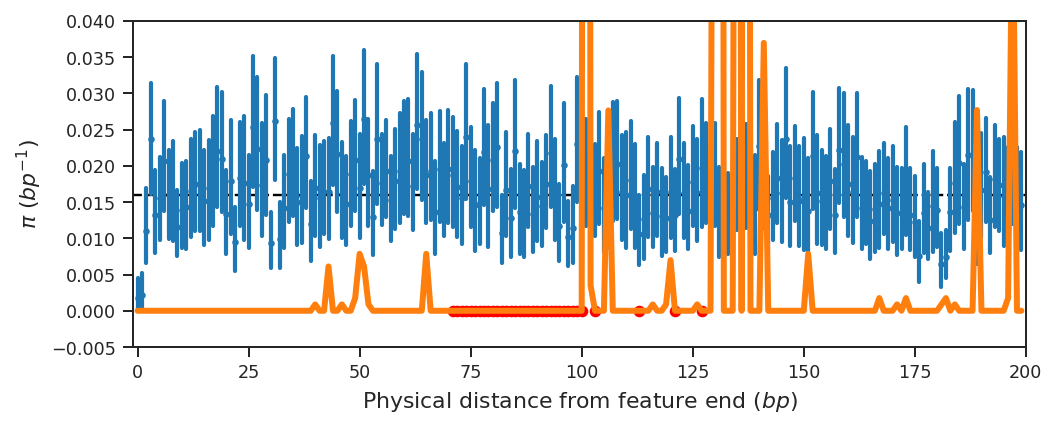

In [10]:
def plot_dsx_against_intron_diversity_end(dsx_data, dsx_acc, title = None):
    
    cls = CLS_INTRON_LAST
    x_max = 200
    y_min = -0.005
    y_max = 0.04
    min_flen = 200

    # compute overall mean
    m = np.mean(seq_mpd[seq_cls == cls])
    
    # obtain variables
    flt = (seq_cls == cls) & (seq_relpos_end < x_max)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos_end[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    # plot the mean data
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    # plot the dsx data
    ax.plot(range(200), dsx_data, lw=3)
    # show accessibility-fitered positions
    ax.scatter(np.array(range(200))[np.invert(dsx_acc)], dsx_data[np.invert(dsx_acc)], lw=1, c = 'red')   
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature end ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    #ax.invert_xaxis()
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

# The blue bars are mean +- 95% conf calculated across 2R. The line shows the observed values for
# the dsx focal intron (organge = accessible, red = inaccessible, bearing in mind that inacessible
# SNPs were not counted, so mpd is always 0 here).
plot_dsx_against_intron_diversity_end(dsx_mpd, dsx_acc)

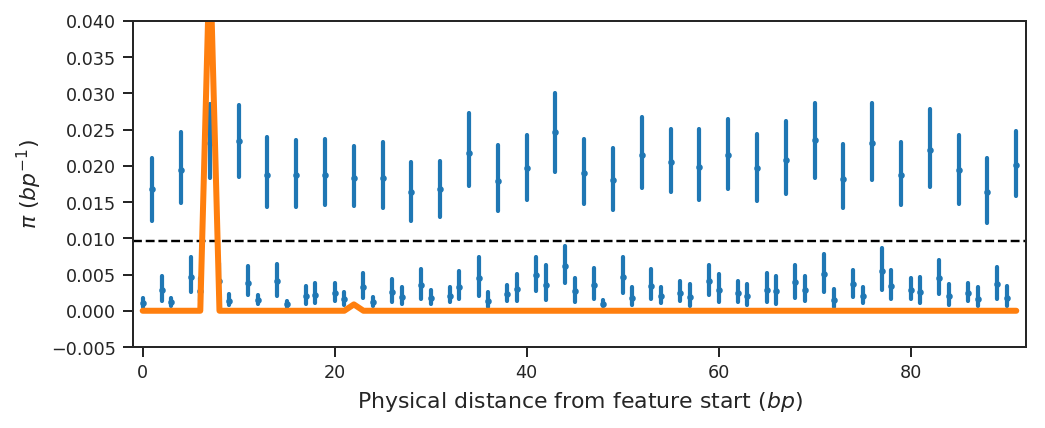

In [11]:
# Now look at the exon diversity
dsx_target_exon = range(Cas9_endpos-103, Cas9_endpos-11)
dsx_target_exon_acc = accessibility_filter[dsx_target_exon]
dsx_target_exon_mpd = seq_mpd_nofilter[dsx_target_exon]

def plot_exon_diversity(dsx_data, dsx_acc, title = None):
    
    cls = [CLS_EXON_LAST]
    x_max = 92
    y_min = -0.005
    y_max = 0.04
    min_flen = 0

    # compute overall mean
    m = np.mean(seq_mpd[np.isin(seq_cls, cls)])
    
    # obtain variables.
    # We take only exons whose first bp is the second coding position (seq_startphase == 2) so that it
    # is in line with the exon that we are plotting here
    flt = np.isin(seq_cls, cls) & (seq_relpos < x_max) & (seq_startphase == 2)
    if min_flen:
        flt = flt & (seq_flen > min_flen)
    dist = seq_relpos[flt]
    values = seq_mpd[flt]

    # plot
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.axhline(m, color='k', linestyle='--')
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6))
    ax.plot(range(92), dsx_data[::-1], lw=3)
    # There are no inaccessible ranges in this region, but keep this bit of code anyway
    ax.scatter(np.array(range(92))[np.invert(dsx_acc)], dsx_data[np.invert(dsx_acc)], lw=1, c = 'red')   
    ax.set_xlim(left=-1, right=x_max)
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Physical distance from feature start ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    #ax.invert_xaxis()
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    plt.show()

# The blue bars are mean +- 95% conf calculated across 2R. The line shows the observed values for
# the dsx focal intron (organge = accessible, red = inaccessible or filtered).
plot_exon_diversity(dsx_target_exon_mpd, dsx_target_exon_acc)

In [12]:
# Get the distribution of values from introns at least 200bp long, but take only the last 100bp of those introns
flt = ((seq_cls == CLS_INTRON_LAST) | (seq_cls == CLS_INTRON_MID) | (seq_cls == CLS_INTRON_FIRST)) & (seq_flen > 200) & (seq_relpos_end < 100)
# If we want to look at only the "last" intron, use this instead
#flt = (seq_cls == CLS_INTRON_LAST) & (seq_flen > 200) & (seq_relpos_end < 100)
values = seq_mpd[flt]

# We use the intron_group_values to separate the mpd values by the intron to which they belong
seq_intron_group_values = seq_intron_group[flt]
seq_relpos_end_values = seq_relpos_end[flt]
values_grouped = pd.Series(values).groupby(seq_intron_group_values)

In [13]:
# Get the mean mpd values for every intron from which we have at least 70 accessible bases among those 
# last 100 bp. This only uses accessible bases as inaccessible bases were removed when seq_mpd was
# calculated.
min_acc_bases = 70
intron_group_sizefilter = values_grouped.size() >= min_acc_bases
intron_group_mpd = values_grouped.mean()[intron_group_sizefilter]
# Now calculate the mean mpd of the last 100 bp dsx intron, removing inaccessible positions. 
dsx_intron_mean_mpd = np.mean(dsx_mpd[:100][dsx_acc[:100]])
# As expected, one of the grouped means is exactly equal to the dsx mean (because dsx is one 
# of the groups):
print(np.sum(intron_group_mpd == dsx_intron_mean_mpd))
# So we remove that value from the group means
intron_group_mpd = intron_group_mpd[np.invert(intron_group_mpd == dsx_intron_mean_mpd)]


1


In [14]:
# What proportion of the distribution is at least as small as the dsx intron?
np.sum(intron_group_mpd <= np.mean(dsx_intron_mean_mpd)) / len(intron_group_mpd)

0.007359705611775529

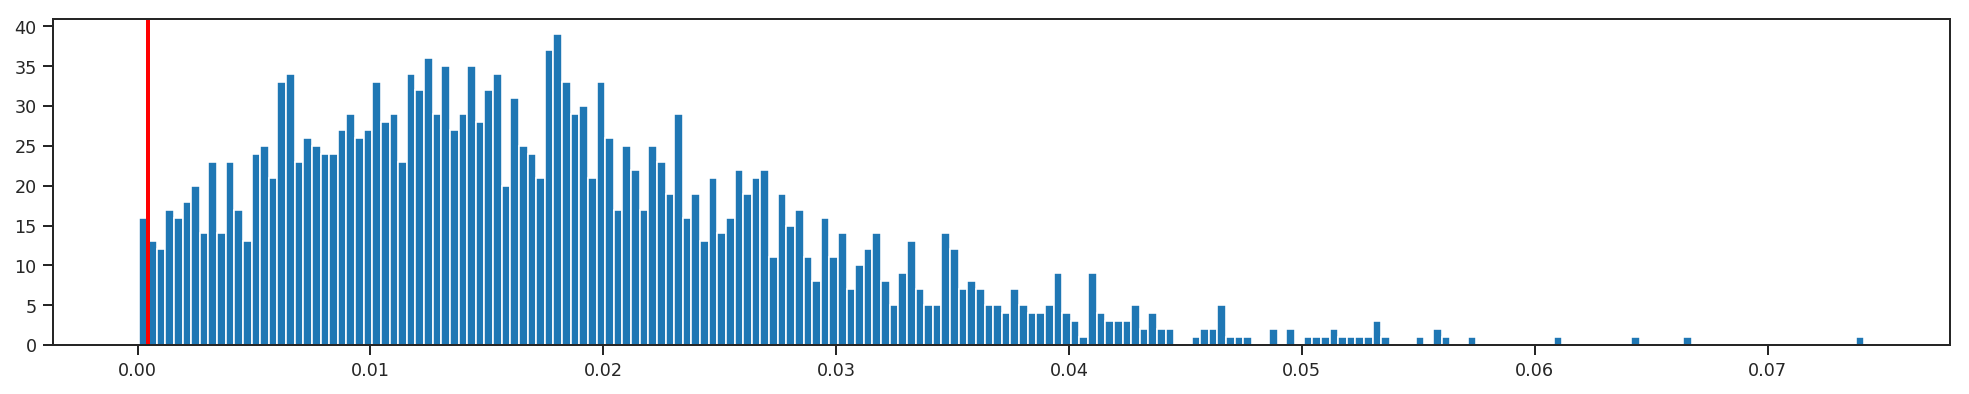

In [15]:
# About 0.7% of values are at least as small as what we observe in the dsx intron.
# Where does that value plot on a histgram?
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(intron_group_mpd, bins = 200)
ax.axvline(dsx_intron_mean_mpd, color='red', lw = 2)
plt.show()

In [16]:
# So while dsx is in the first percentile of the distribution, I wouldn't call it an outlier. 
# Doing a test of statistical significance doesn't really makes sense, I think. I feel that the 
# question "is this intron significantly different from the other introns" would only make sense
# if this intron was an outlier, which it doesn't really appear to be from the distribution above.
# Still, just for completeness, let's see what happens when we do a Mann-Whitney U test.
from scipy.stats import mannwhitneyu
mannwhitneyu([dsx_intron_mean_mpd], intron_group_mpd)
# It's borderline significant

MannwhitneyuResult(statistic=16.0, pvalue=0.044099520149245855)

0.0


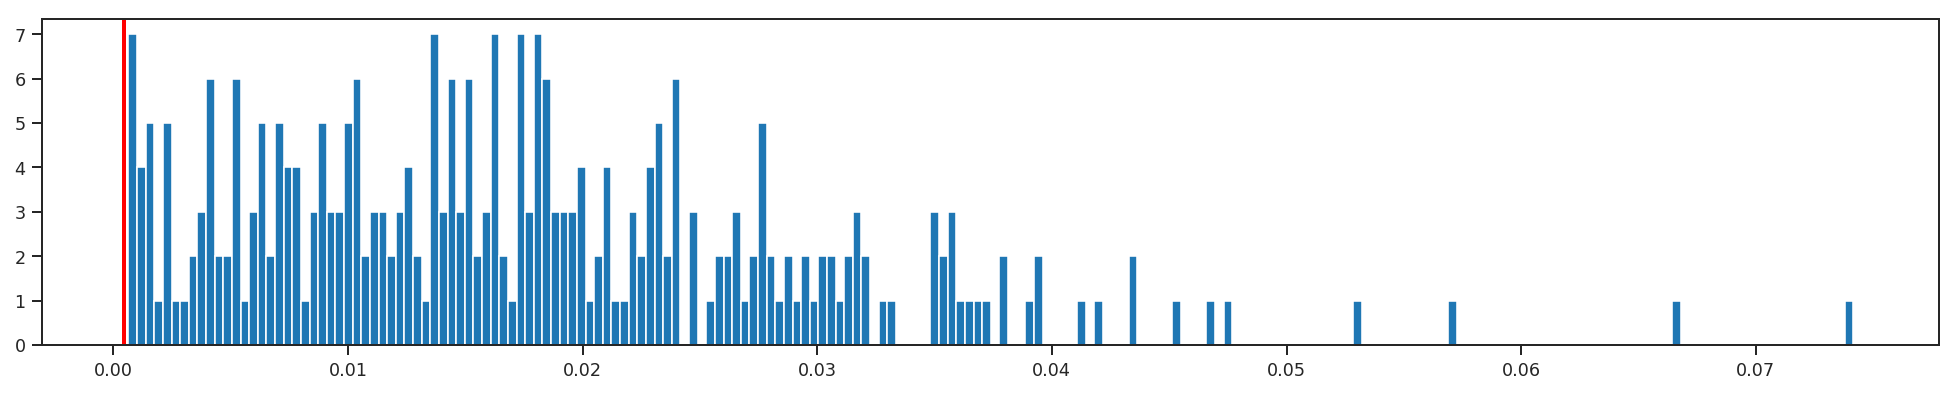

292


MannwhitneyuResult(statistic=0.0, pvalue=0.042694598281353933)

In [17]:
# If we only use "last" introns as the background, we get a significant result, but there is a much 
# smaller sample size to create the distribution
flt = (seq_cls == CLS_INTRON_LAST) & (seq_flen > 200) & (seq_relpos_end < 100)
values = seq_mpd[flt]
seq_intron_group_values = seq_intron_group[flt]
seq_relpos_end_values = seq_relpos_end[flt]
values_grouped = pd.Series(values).groupby(seq_intron_group_values)
intron_group_sizefilter = values_grouped.size() >= min_acc_bases
intron_group_mpd = values_grouped.mean()[intron_group_sizefilter]
# Remove the dsx value from the background distribution
intron_group_mpd = intron_group_mpd[np.invert(intron_group_mpd == dsx_intron_mean_mpd)]
print(np.sum(intron_group_mpd <= np.mean(dsx_intron_mean_mpd)) / len(intron_group_mpd))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(intron_group_mpd, bins = 200)
ax.axvline(dsx_intron_mean_mpd, color='red', lw = 2)
plt.show()
print(len(intron_group_mpd))
# So none of the 292 other last introns have 0 variation. 
mannwhitneyu([dsx_intron_mean_mpd], intron_group_mpd)

1
0.08085106382978724


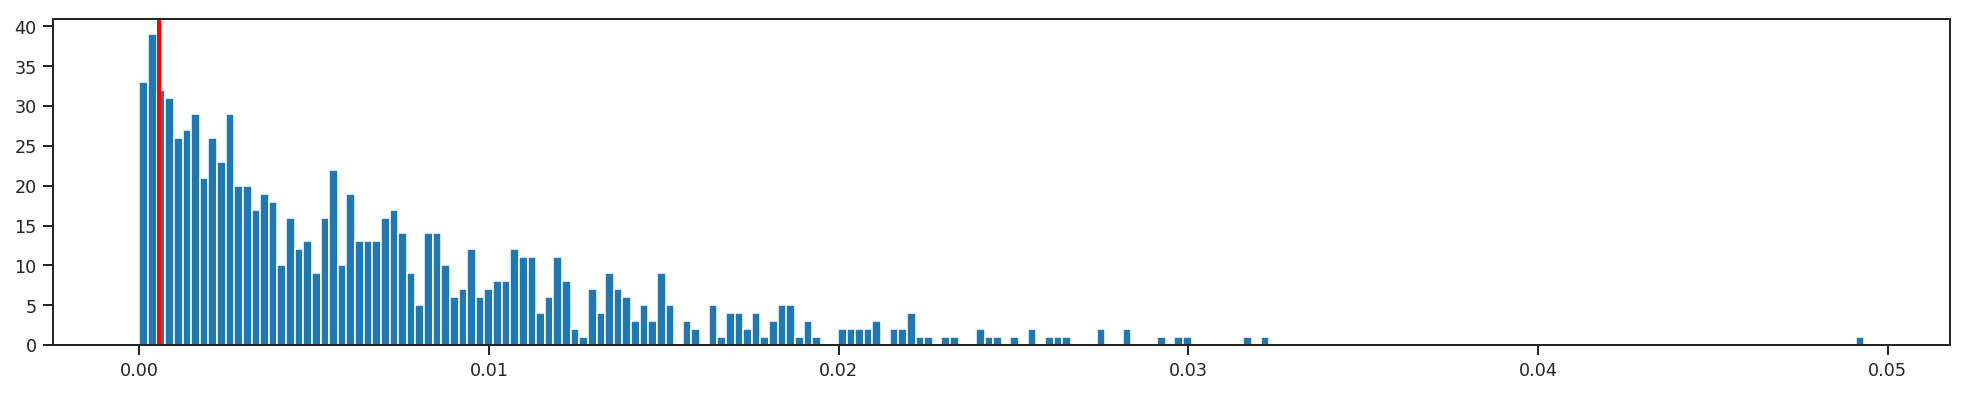

940


MannwhitneyuResult(statistic=76.0, pvalue=0.07372582461894724)

In [18]:
# Now do these calculations for the exon
flt = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 100)
values = seq_mpd[flt]
seq_exon_group_values = seq_exon_group[flt]
seq_relpos_end_values = seq_relpos_end[flt]
values_grouped = pd.Series(values).groupby(seq_exon_group_values)
exon_group_sizefilter = values_grouped.size() >= min_acc_bases
exon_group_mpd = values_grouped.mean()[exon_group_sizefilter]
dsx_exon_mean_mpd = np.mean(dsx_target_exon_mpd[dsx_target_exon_acc])
# As expected, one of the grouped means is exactly equal to the dsx mean (because dsx is one 
# of the groups):
print(np.sum(exon_group_mpd == dsx_exon_mean_mpd))
# So we remove that value from the group means
exon_group_mpd = exon_group_mpd[np.invert(exon_group_mpd == dsx_exon_mean_mpd)]
print(np.sum(exon_group_mpd <= np.mean(dsx_exon_mean_mpd)) / len(exon_group_mpd))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd, bins = 200)
ax.axvline(dsx_exon_mean_mpd, color='red', lw = 2)
plt.show()
print(len(exon_group_mpd))
mannwhitneyu([dsx_exon_mean_mpd], exon_group_mpd)
#8% of genes have at least as little variation as this exon

1
0.07746478873239436


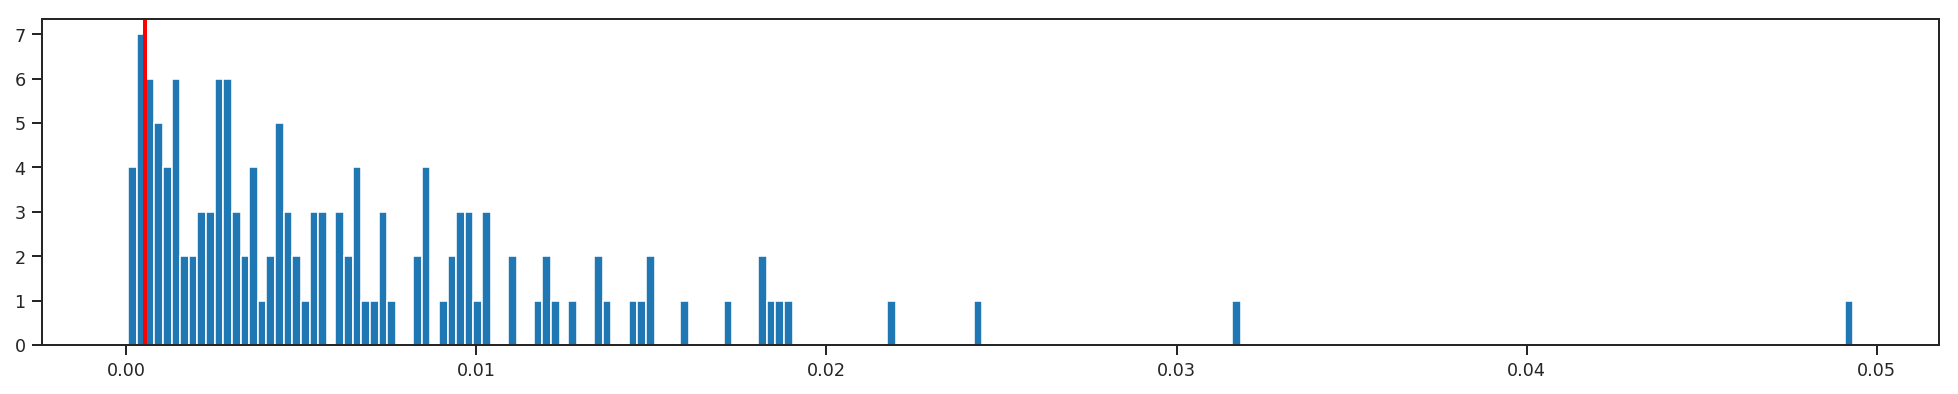

142


MannwhitneyuResult(statistic=10.5, pvalue=0.07304162413041179)

In [19]:
# Now using only the last exon
flt = (seq_cls == CLS_EXON_LAST) & (seq_flen < 100)
values = seq_mpd[flt]
seq_exon_group_values = seq_exon_group[flt]
seq_relpos_end_values = seq_relpos_end[flt]
values_grouped = pd.Series(values).groupby(seq_exon_group_values)
exon_group_sizefilter = values_grouped.size() >= min_acc_bases
exon_group_mpd = values_grouped.mean()[exon_group_sizefilter]
# The dsx exon we are looking at is not in the distribution because it is an RB transcript
print(np.sum(exon_group_mpd == dsx_exon_mean_mpd))
print(np.sum(exon_group_mpd <= np.mean(dsx_exon_mean_mpd)) / len(exon_group_mpd))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd, bins = 200)
ax.axvline(dsx_exon_mean_mpd, color='red', lw = 2)
plt.show()
print(len(exon_group_mpd))
mannwhitneyu([dsx_exon_mean_mpd], exon_group_mpd)
#8% of genes have at least as little variation as this exon

In [20]:
# OK, now we want to do this across the whole gene. 

In [21]:
# Re-calculate some of the feature tables calculated inside the compute_features function, but this
# time make them globally visible.

tbl_features = (
    get_features(chrom)
    .convert('start', lambda v: v-1)
    .rename('end', 'stop')
    .unpackdict('attributes', ['Parent', 'ID'])
    .rename('Parent', 'parent')
    .addfield('length', lambda rec: rec.stop-rec.start, index=5)
    .cache()
)
tbl_genes = tbl_features.eq('type', 'gene')    

# obtain CDSs
##############

def child_first(prv, cur, nxt):
    return (
        (cur.strand == '+' and (prv is None or prv.parent != cur.parent))
        or (cur.strand == '-') and (nxt is None or cur.parent != nxt.parent)
    )

def child_last(prv, cur, nxt):
    return (
        (cur.strand == '-' and (prv is None or prv.parent != cur.parent))
        or (cur.strand == '+') and (nxt is None or cur.parent != nxt.parent)
    )

tbl_cdss = (
    tbl_features
    .eq('type', 'CDS')
    .select('parent', lambda v: v.endswith('RA'))
    .addfieldusingcontext('first', child_first)
    .addfieldusingcontext('last', child_last)
)    

# obtain introns
#################

def cds2intron(parent, cdss):
    cdss = list(cdss)
    seqid = cdss[0].seqid
    strand = cdss[0].strand
    type = 'intron'
    for i in range(1, len(cdss)):
        start = cdss[i-1].stop
        stop = cdss[i].start
        yield (seqid, type, start, stop, stop-start, strand, parent)

tbl_introns = (
    tbl_cdss
    .rowgroupmap(key='parent', mapper=cds2intron, header=['seqid', 'type', 'start', 'stop', 'length', 'strand', 'parent'])
    .addfieldusingcontext('first', child_first)
    .addfieldusingcontext('last', child_last)
)

In [22]:
# Show the introns
pd.DataFrame(np.array(etl.search(tbl_introns, 'AGAP004050')))

,0,1,2,3,4,5,6,7,8
0,seqid,type,start,stop,length,strand,parent,first,last
1,2R,intron,48714648,48715160,512,-,AGAP004050-RA,False,True
2,2R,intron,48715295,48747692,32397,-,AGAP004050-RA,False,False
3,2R,intron,48747737,48784184,36447,-,AGAP004050-RA,True,False


In [23]:
# And all CDS features (for both splice variants)
pd.DataFrame(np.array(etl.search(tbl_features, 'AGAP004050').eq('type', 'CDS')))

,0,1,2,3,4,5,6,7,8,9,10
0,seqid,source,type,start,stop,length,score,strand,phase,parent,ID
1,2R,VectorBase,CDS,48711598,48712794,1196,.,-,2,AGAP004050-RB,AGAP004050-PB
2,2R,VectorBase,CDS,48714556,48714648,92,.,-,2,AGAP004050-RA,AGAP004050-PA
3,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RA,AGAP004050-PA
4,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RB,AGAP004050-PB
5,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RA,AGAP004050-PA
6,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RB,AGAP004050-PB
7,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RA,AGAP004050-PA
8,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RB,AGAP004050-PB


In [24]:
# Some all of the introns are long, but some of the exons are short (45 or 92 bp)

# The start and end of the dsx gene are at 48703663 and 48788460

In [25]:
# OK, first off, how does mean mpd correlate with intron length?
# Get the positions of interest 
intron_positions = (seq_cls == CLS_INTRON_LAST) | (seq_cls == CLS_INTRON_MID) | (seq_cls == CLS_INTRON_FIRST)
# If we want to look at only the "last" intron, use this instead
#flt = seq_cls == CLS_INTRON_LAST
intron_values = seq_mpd[intron_positions]

# We separate the mpd values by the intron to which they belong
seq_intron_group_values_2 = seq_intron_group[intron_positions]
intron_values_grouped = pd.Series(intron_values).groupby(seq_intron_group_values_2)

intron_group_sizes = intron_values_grouped.size()
intron_group_mpd_2 = intron_values_grouped.mean()

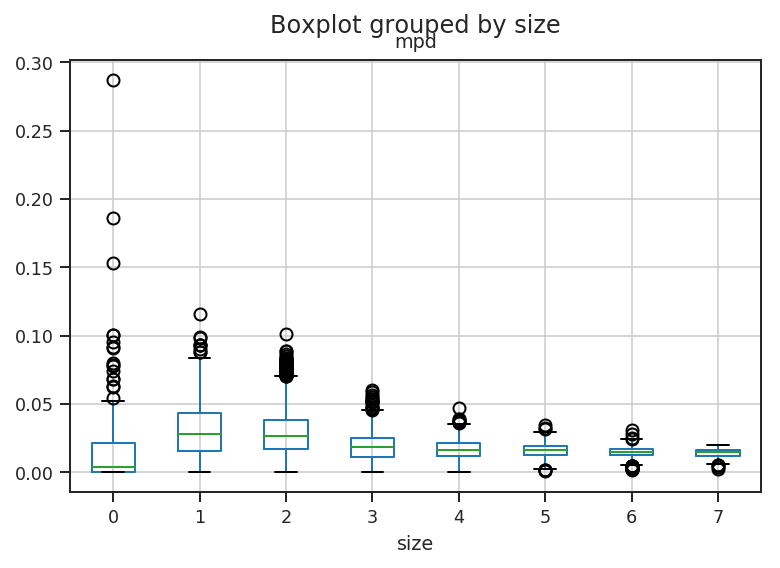

In [26]:
# We can bin introns by size and do some boxplots
intron_size_bins = ((intron_group_sizes > 20).astype(int) +
    (intron_group_sizes > 50).astype(int) +
    (intron_group_sizes > 100).astype(int) +
    (intron_group_sizes > 200).astype(int) +
    (intron_group_sizes > 500).astype(int) +
    (intron_group_sizes > 1000).astype(int) +
    (intron_group_sizes > 10000).astype(int))
intron_mpd_by_size = intron_group_mpd_2.groupby(intron_size_bins)

pd.DataFrame({'size': intron_size_bins, 'mpd': intron_group_mpd_2}).boxplot(column = 'mpd', by = 'size')

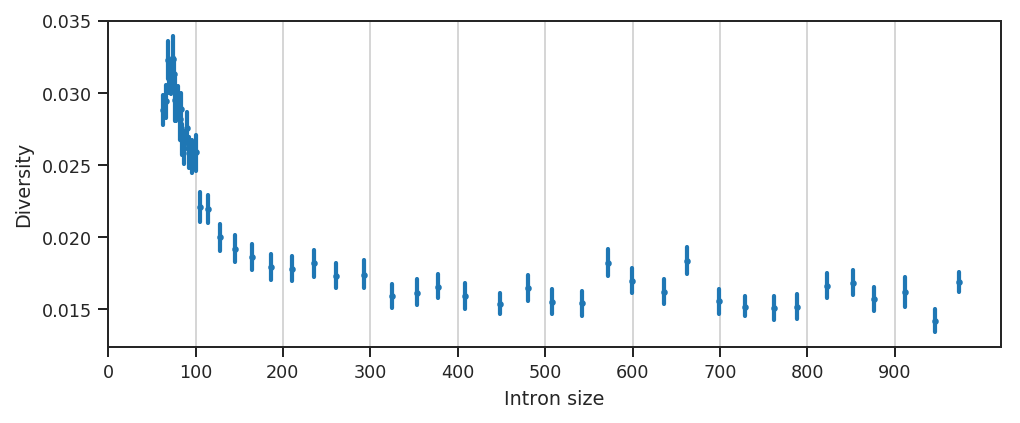

In [27]:
# Or we take bin sizes of 50 and stop when we get to 1000
intron_positions_1000 = ((seq_cls == CLS_INTRON_LAST) | (seq_cls == CLS_INTRON_MID) | (seq_cls == CLS_INTRON_FIRST)) & (seq_flen < 1000)
intron_values_1000 = seq_mpd[intron_positions_1000]
intron_sizes_1000 = seq_flen[intron_positions_1000]
fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(intron_sizes_1000, intron_values_1000, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
ax.set_xlabel('Intron size')
ax.set_ylabel('Diversity')
plt.xticks(range(0,1000, 100))
ax.xaxis.grid()
plt.show()



In [28]:
# For introns, we are probably happy with taking a size cut-off of 300, since the smallest intron in dsx
# is 500bp. Let's look at the distribution of mean mpd for all introns of this size and see where the 
# three dsx introns fit in
# First, get the mean mpd in each of the three introns of dsx
dsx_intron_start_pos = etl.columns(etl.search(tbl_introns, 'AGAP004050'))['start']
dsx_intron_end_pos = etl.columns(etl.search(tbl_introns, 'AGAP004050'))['stop']

In [29]:
# Get the accessibility and mpd for each intron as a list
dsx_intron_ranges = [range(dsx_intron_start_pos[i], dsx_intron_end_pos[i]) for i in range(len(dsx_intron_start_pos))]
dsx_intron_acc = [accessibility_filter[dsx_intron_ranges[i]] for i in range(len(dsx_intron_ranges))]
dsx_intron_mpd = [seq_mpd_nofilter[dsx_intron_ranges[i]] for i in range(len(dsx_intron_ranges))]
# Now get the mean of accessible mpds
dsx_intron_mean_mpd = [np.mean(dsx_intron_mpd[i][dsx_intron_acc[i]]) for i in range(len(dsx_intron_ranges))]
dsx_intron_mean_mpd

[0.014092119385156265, 0.009772479090061416, 0.009856899177020881]

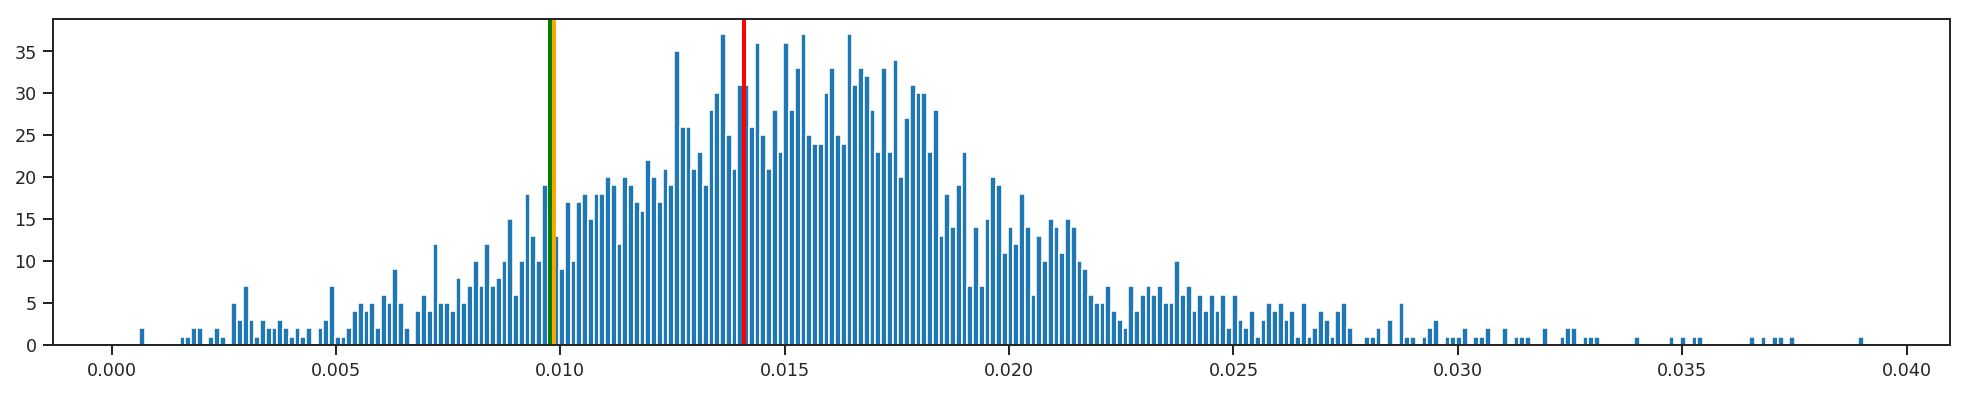

In [30]:
# Now plot the histogram of all mean mpds and show where the 3 dsx introns lie
intron_positions_300min = ((seq_cls == CLS_INTRON_LAST) | (seq_cls == CLS_INTRON_MID) | (seq_cls == CLS_INTRON_FIRST)) & (seq_flen > 300)
intron_values_300min = seq_mpd[intron_positions_300min]
seq_intron_group_values_300min = seq_intron_group[intron_positions_300min]
intron_values_grouped_300min = pd.Series(intron_values_300min).groupby(seq_intron_group_values_300min)
intron_group_sizefilter_300min = intron_values_grouped_300min.size() >= min_acc_bases
intron_group_mpd_300min = intron_values_grouped_300min.mean()[intron_group_sizefilter_300min]
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(intron_group_mpd_300min, bins = 300)
ax.axvline(dsx_intron_mean_mpd[0], color='red', lw = 2)
ax.axvline(dsx_intron_mean_mpd[1], color='green', lw = 2)
ax.axvline(dsx_intron_mean_mpd[2], color='orange', lw = 2)
plt.show()


In [31]:
# Let's confirm that each of those introns is indeed present in the distribution
print(np.sum(np.round(intron_group_mpd_300min, 10) == np.round(dsx_intron_mean_mpd[0], 10)))
print(np.sum(np.round(intron_group_mpd_300min, 10) == np.round(dsx_intron_mean_mpd[1], 10)))
print(np.sum(np.round(intron_group_mpd_300min, 10) == np.round(dsx_intron_mean_mpd[2], 10)))

1
0
1


In [32]:
# The calculated value for the second intron is not found in our distribution of all introns. I happen
# to know that the group number for this intron in the distribution is 8247. We can see that the values
# are not the same. 
print(dsx_intron_mean_mpd[1])
print(np.mean(intron_values_grouped_300min.get_group(8247)))
# The reason for this is that this intron contains an entire gene on the other strand. Given the way that
# introns and CDS regions are determined, the CDS of the other gene still gets coded as intronic region 
# 8247 (which we may want to deal with at some point). However, the intronic regions of the other strand
# overwrite the intronic region of dsx, and thus are given a new group number. This is what gets used to 
# calculate the value in the distribution. On the other hand, our targeted calculation of the dsx intron
# just uses the positions between the start and end points of the intron, so those regions that are also 
# introns in the other gene also get counted. The difference in value is not huge, so let's leave it for 
# now and maybe we'll come back to it later. 

0.009772479090061416
0.009737383268979835


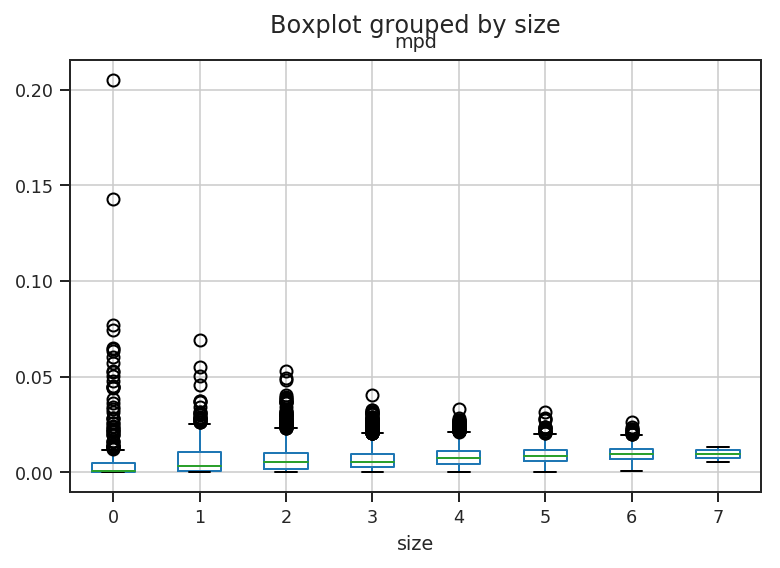

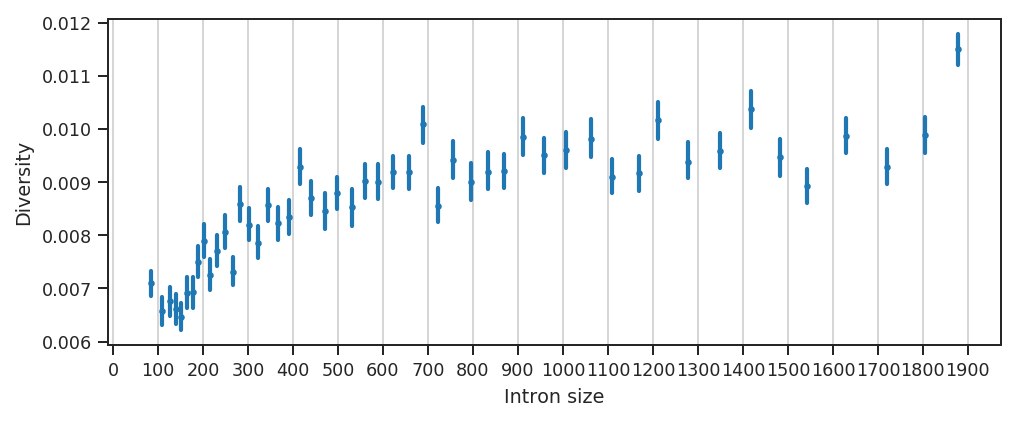

In [33]:
# Now let's do the same for exons
exon_positions = (seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)
exon_values = seq_mpd[exon_positions]

# We separate the mpd values by the intron to which they belong
seq_exon_group_values = seq_exon_group[exon_positions]
exon_values_grouped = pd.Series(exon_values).groupby(seq_exon_group_values)

exon_group_sizes = exon_values_grouped.size()
exon_group_mpd = exon_values_grouped.mean()

exon_size_bins = ((exon_group_sizes > 20).astype(int) +
    (exon_group_sizes > 50).astype(int) +
    (exon_group_sizes > 100).astype(int) +
    (exon_group_sizes > 200).astype(int) +
    (exon_group_sizes > 500).astype(int) +
    (exon_group_sizes > 1000).astype(int) +
    (exon_group_sizes > 10000).astype(int))
exon_mpd_by_size = exon_group_mpd.groupby(exon_size_bins)

pd.DataFrame({'size': exon_size_bins, 'mpd': exon_group_mpd}).boxplot(column = 'mpd', by = 'size')

exon_positions_2000 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 2000)
exon_values_2000 = seq_mpd[exon_positions_2000]
exon_sizes_2000 = seq_flen[exon_positions_2000]
fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(exon_sizes_2000, exon_values_2000, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
ax.set_xlabel('Intron size')
ax.set_ylabel('Diversity')
plt.xticks(range(0,2000, 100))
ax.xaxis.grid()
plt.show()

In [34]:
# Remind ourselves of the size of dsx exons. 
pd.DataFrame(np.array(etl.search(tbl_features, 'AGAP004050').eq('type', 'CDS')))

,0,1,2,3,4,5,6,7,8,9,10
0,seqid,source,type,start,stop,length,score,strand,phase,parent,ID
1,2R,VectorBase,CDS,48711598,48712794,1196,.,-,2,AGAP004050-RB,AGAP004050-PB
2,2R,VectorBase,CDS,48714556,48714648,92,.,-,2,AGAP004050-RA,AGAP004050-PA
3,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RA,AGAP004050-PA
4,2R,VectorBase,CDS,48715160,48715295,135,.,-,2,AGAP004050-RB,AGAP004050-PB
5,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RA,AGAP004050-PA
6,2R,VectorBase,CDS,48747692,48747737,45,.,-,2,AGAP004050-RB,AGAP004050-PB
7,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RA,AGAP004050-PA
8,2R,VectorBase,CDS,48784184,48784710,526,.,-,0,AGAP004050-RB,AGAP004050-PB


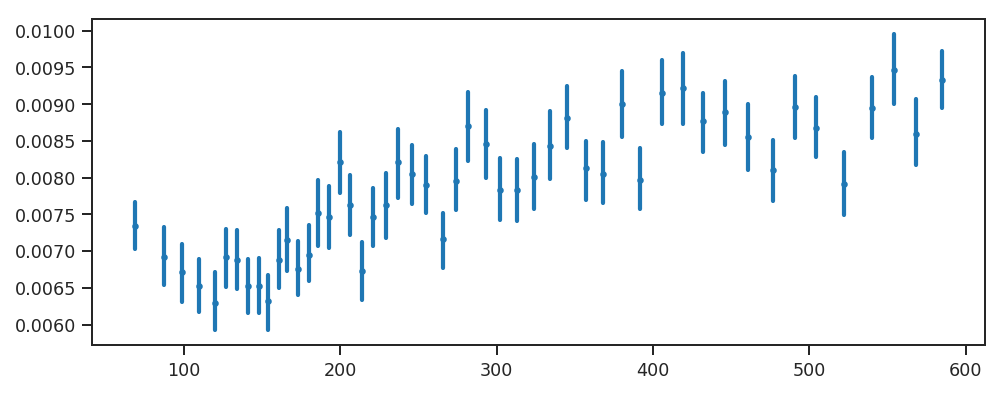

In [35]:
# These are quite small exons, which is problematic for comparing them to the expectation, since
# the expectation in this size range is very dependent on exon size. Let's look again at the 
# relationship with size, but zooming in to smaller exons
exon_positions_600 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 600)
exon_values_600 = seq_mpd[exon_positions_600]
exon_sizes_600 = seq_flen[exon_positions_600]
fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(exon_sizes_600, exon_values_600, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6))
plt.show()

In [36]:
# Get the start and end points of the exons. The tbl_cdss object only has the RA splice variants, 
# so we manually add the final RB exon
dsx_exon_start_pos =  [48711598] + etl.columns(etl.search(tbl_cdss, 'AGAP004050'))['start']
dsx_exon_end_pos =  [48712794] + etl.columns(etl.search(tbl_cdss, 'AGAP004050'))['stop']
dsx_exon_ranges = [range(dsx_exon_start_pos[i], dsx_exon_end_pos[i]) for i in range(len(dsx_exon_start_pos))]
# Get the accessibility and mpd for each exon as a list
dsx_exon_acc = [accessibility_filter[dsx_exon_ranges[i]] for i in range(len(dsx_exon_ranges))]
dsx_exon_mpd = [seq_mpd_nofilter[dsx_exon_ranges[i]] for i in range(len(dsx_exon_ranges))]
# Now get the mean of accessible mpds
dsx_exon_mean_mpd = [np.mean(dsx_exon_mpd[i][dsx_exon_acc[i]]) for i in range(len(dsx_exon_ranges))]

# Now get the same means, but split by coding position. For each exon, we want the coding position 
# relative to the start of the whole CDS, not the start of that exon. Since there are two splice 
# variants, it's easiest to do this exon-by-exon rather than in a loop
dsx_exon_relpos = [seq_relpos_nofilter[x] for x in dsx_exon_ranges]
dsx_exon_cumulative_length = np.cumsum([len(x) for x in dsx_exon_relpos][::-1])[::-1]
dsx_exon_total_relpos = [[]]*5
dsx_exon_total_relpos[4] = dsx_exon_relpos[4]
dsx_exon_total_relpos[3] = dsx_exon_relpos[3] + dsx_exon_cumulative_length[4]
dsx_exon_total_relpos[2] = dsx_exon_relpos[2] + dsx_exon_cumulative_length[3]
dsx_exon_total_relpos[1] = dsx_exon_relpos[1] + dsx_exon_cumulative_length[2]
# The alternative exon does not get classified as an exon by the automatic process (which only considers
# RA transcripts) and so does not have a relpos assigned to it. So we just created it manually
dsx_exon_total_relpos[0] = dsx_exon_cumulative_length[2] + range(len(dsx_exon_ranges[0]))[::-1]
# Get the mean mpd in each of the four exons of dsx. We don't use the codon position calculated for the
# whole gneome here because that only considered RA transcripts, so we would miss out on the last female
# exon
dsx_exon_mpd_1 = [dsx_exon_mpd[i][dsx_exon_total_relpos[i]%3 == 0] for i in range(len(dsx_exon_ranges))]
dsx_exon_mpd_2 = [dsx_exon_mpd[i][dsx_exon_total_relpos[i]%3 == 1] for i in range(len(dsx_exon_ranges))]
dsx_exon_mpd_3 = [dsx_exon_mpd[i][dsx_exon_total_relpos[i]%3 == 2] for i in range(len(dsx_exon_ranges))]
dsx_exon_acc_1 = [dsx_exon_acc[i][dsx_exon_total_relpos[i]%3 == 0] for i in range(len(dsx_exon_ranges))]
dsx_exon_acc_2 = [dsx_exon_acc[i][dsx_exon_total_relpos[i]%3 == 1] for i in range(len(dsx_exon_ranges))]
dsx_exon_acc_3 = [dsx_exon_acc[i][dsx_exon_total_relpos[i]%3 == 2] for i in range(len(dsx_exon_ranges))]
#
dsx_exon_mean_mpd_1 = [np.mean(dsx_exon_mpd_1[i][dsx_exon_acc_1[i]]) for i in range(len(dsx_exon_ranges))]
dsx_exon_mean_mpd_2 = [np.mean(dsx_exon_mpd_2[i][dsx_exon_acc_2[i]]) for i in range(len(dsx_exon_ranges))]
dsx_exon_mean_mpd_3 = [np.mean(dsx_exon_mpd_3[i][dsx_exon_acc_3[i]]) for i in range(len(dsx_exon_ranges))]



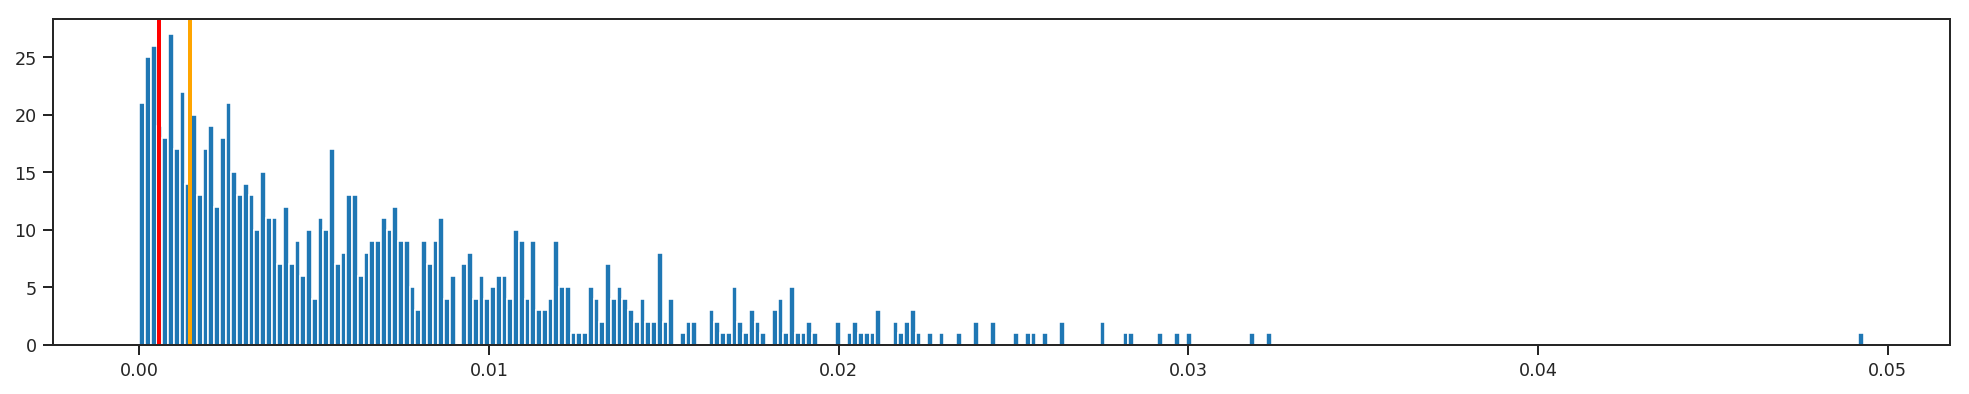

0.0818278427205101
0.19659936238044634


In [37]:
# Let's use exons smaller than 100 for the two smallest exons
exon_positions_100max = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen < 100)
exon_values_100max = seq_mpd[exon_positions_100max]
seq_exon_group_values_100max = seq_exon_group[exon_positions_100max]
exon_values_grouped_100max = pd.Series(exon_values_100max).groupby(seq_exon_group_values_100max)
exon_group_sizefilter_100max = exon_values_grouped_100max.size() >= min_acc_bases
exon_group_mpd_100max = exon_values_grouped_100max.mean()[exon_group_sizefilter_100max]
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100max, bins = 300)
ax.axvline(dsx_exon_mean_mpd[1], color='red', lw = 2)
ax.axvline(dsx_exon_mean_mpd[3], color='orange', lw = 2)
plt.show()
# What proportion of the distribution is at least as small as each of those exons?
print(np.sum(exon_group_mpd_100max <= np.mean(dsx_exon_mean_mpd[1])) / len(exon_group_mpd_100max))
print(np.sum(exon_group_mpd_100max <= np.mean(dsx_exon_mean_mpd[3])) / len(exon_group_mpd_100max))
# It's 8% and 20%
# The reason that the value here of 8% isn't quite the same as when we first looked at the Cas9 target
# exon (which is exon [1]) is that here we haven't been removing the exon itself from the distribution.

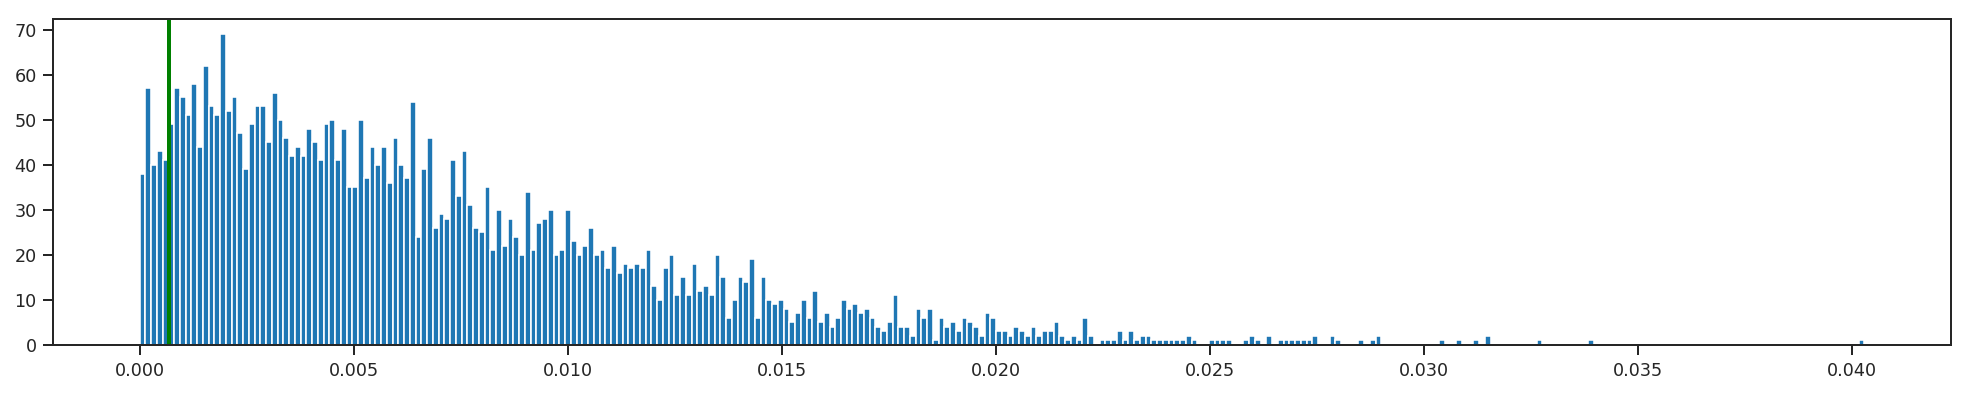

0.056990881458966566

In [38]:
# For the 135bp-long exon, we use the 100-200 size range
exon_positions_100_200 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen > 100) & (seq_flen < 200)
exon_values_100_200 = seq_mpd[exon_positions_100_200]
seq_exon_group_values_100_200 = seq_exon_group[exon_positions_100_200]
exon_values_grouped_100_200 = pd.Series(exon_values_100_200).groupby(seq_exon_group_values_100_200)
exon_group_sizefilter_100_200 = exon_values_grouped_100_200.size() >= min_acc_bases
exon_group_mpd_100_200 = exon_values_grouped_100_200.mean()[exon_group_sizefilter_100_200]
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100_200, bins = 300)
ax.axvline(dsx_exon_mean_mpd[2], color='green', lw = 2)
plt.show()
# What proportion of the distribution is at least as small as the red vertical bar?
np.sum(exon_group_mpd_100_200 <= np.mean(dsx_exon_mean_mpd[2])) / len(exon_group_mpd_100_200)
# It's 6%

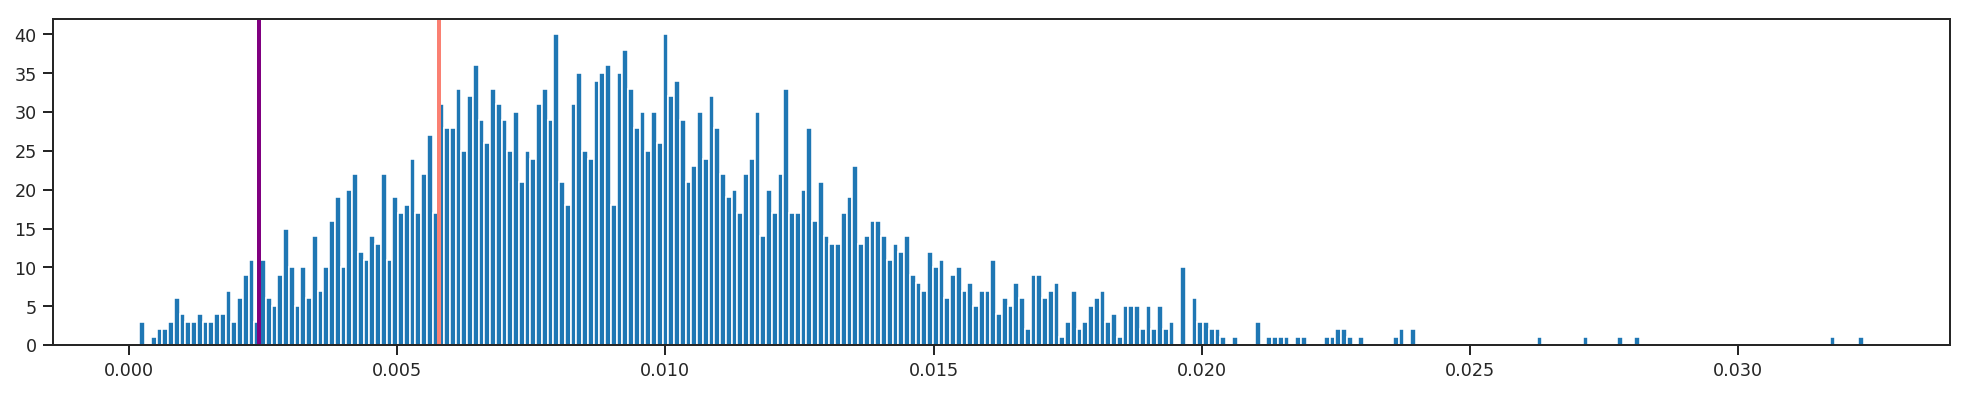

0.028749567024593
0.18150329061309317


In [39]:
# For the two longer exons, we use the 500+ distribution
exon_positions_500plus = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_flen > 500)
exon_values_500plus = seq_mpd[exon_positions_500plus]
seq_exon_group_values_500plus = seq_exon_group[exon_positions_500plus]
exon_values_grouped_500plus = pd.Series(exon_values_500plus).groupby(seq_exon_group_values_500plus)
exon_group_sizefilter_500plus = exon_values_grouped_500plus.size() >= min_acc_bases
exon_group_mpd_500plus = exon_values_grouped_500plus.mean()[exon_group_sizefilter_500plus]
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_500plus, bins = 300)
ax.axvline(dsx_exon_mean_mpd[4], color='purple', lw = 2)
ax.axvline(dsx_exon_mean_mpd[0], color='salmon', lw = 2)
plt.show()
# What proportion of the distribution is at least as small as the exon?
print(np.sum(exon_group_mpd_500plus <= np.mean(dsx_exon_mean_mpd[4])) / len(exon_group_mpd_500plus))
print(np.sum(exon_group_mpd_500plus <= np.mean(dsx_exon_mean_mpd[0])) / len(exon_group_mpd_500plus))
# For the first exon, it's 3%

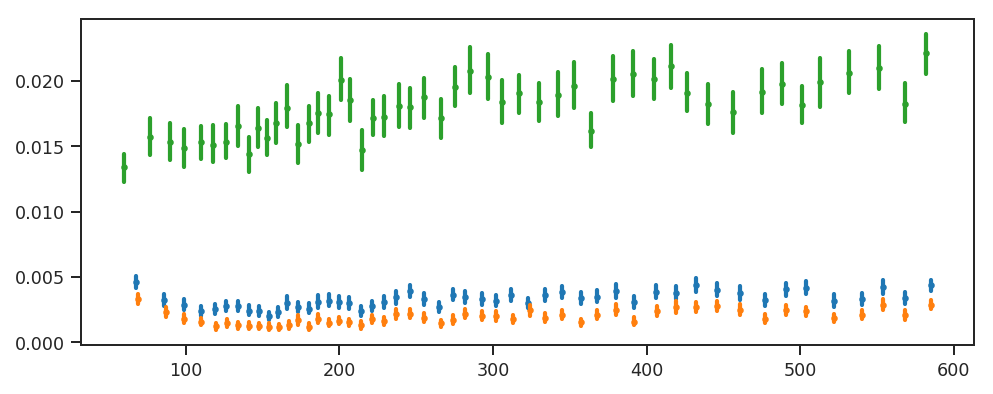

In [40]:
# Let's look at the distribution of exon diversity, separating by coding position
# Use relative position and isolate the ones that are multiples of 3 + 0, 1 or 2 from start 
# in the first exon, or from the end in the last exon
# First coding position:
exon_positions_600_1 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_codonpos == 1) & (seq_flen < 600)
exon_values_600_1 = seq_mpd[exon_positions_600_1]
exon_sizes_600_1 = seq_flen[exon_positions_600_1]

# Second coding position
exon_positions_600_2 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_codonpos == 2)  & (seq_flen < 600)
exon_values_600_2 = seq_mpd[exon_positions_600_2]
exon_sizes_600_2 = seq_flen[exon_positions_600_2]

# Third coding position
exon_positions_600_3 = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_codonpos == 3)  & (seq_flen < 600) & (seq_relpos%3 == 2)
exon_values_600_3 = seq_mpd[exon_positions_600_3]
exon_sizes_600_3 = seq_flen[exon_positions_600_3]

fig, ax = plt.subplots(figsize=(8, 3))
sns.regplot(exon_sizes_600_1, exon_values_600_1, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6), color = 'tab:blue')
sns.regplot(exon_sizes_600_2, exon_values_600_2, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6), color = 'tab:orange')
sns.regplot(exon_sizes_600_3, exon_values_600_3, x_bins = 50, fit_reg = False, ax=ax, scatter_kws=dict(s=6), color = 'tab:green')
plt.show()

In [41]:
# Diversity is lower at the second coding position. Is that what we expect?

First coding position:
0.1263482280431433
0.463020030816641


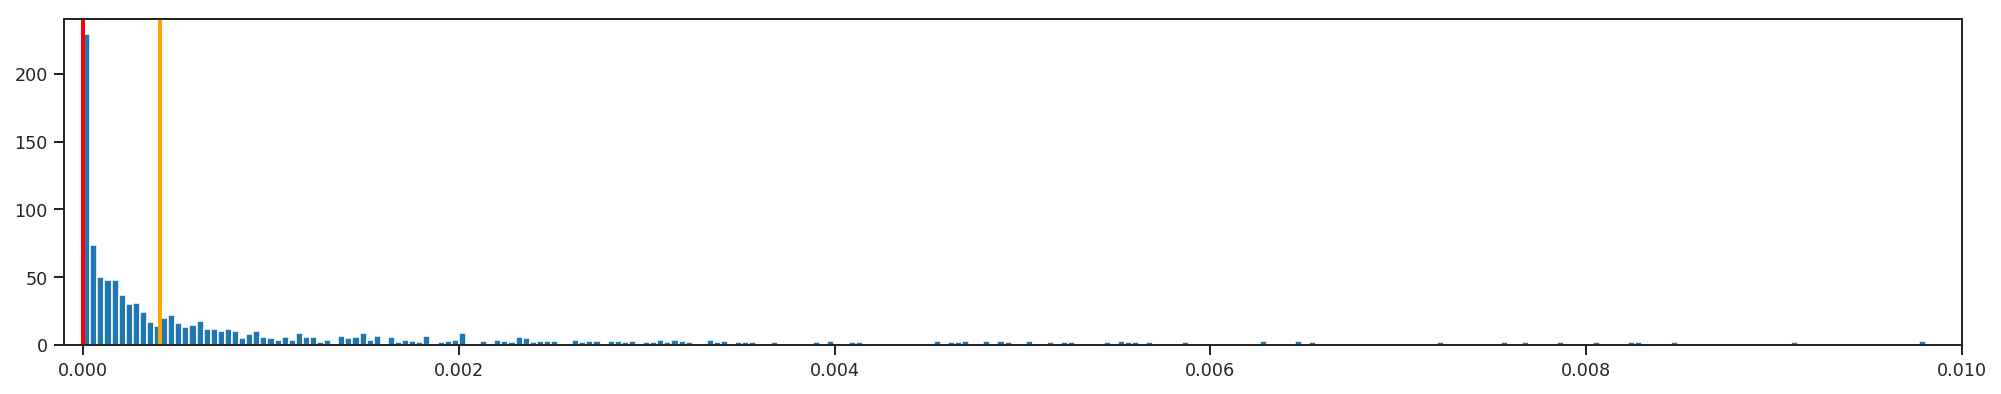

Second coding position:
0.24573643410852714
0.24573643410852714


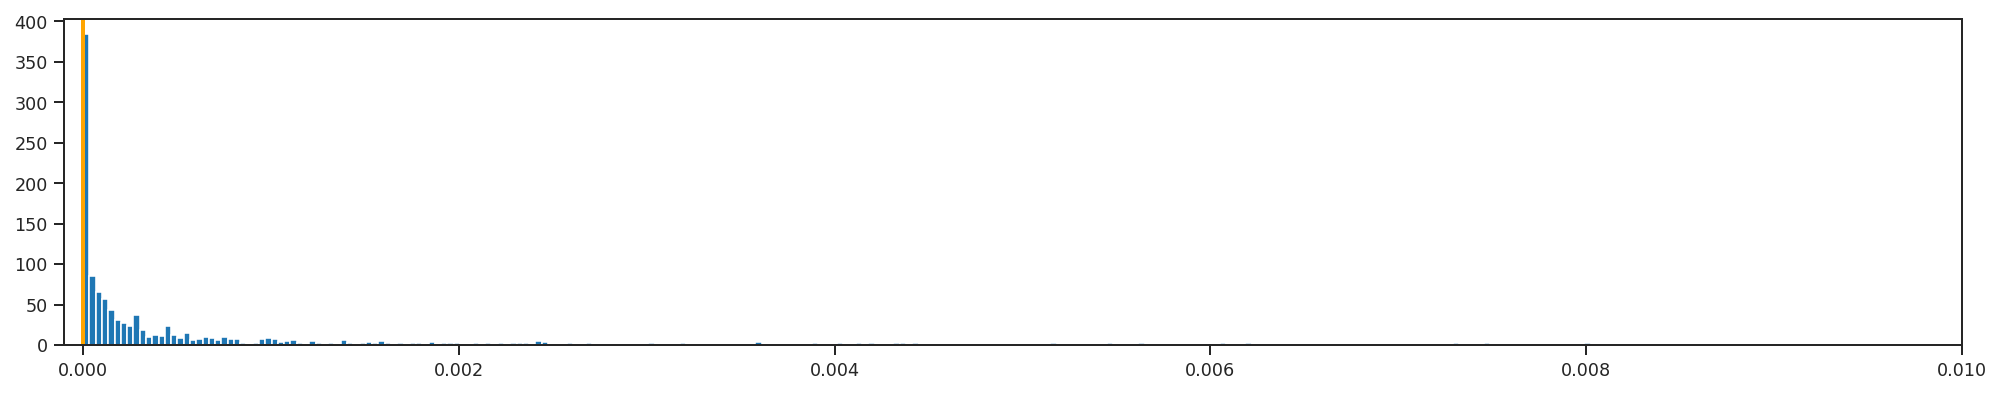

Third coding position:
0.12050078247261346
0.24804381846635368


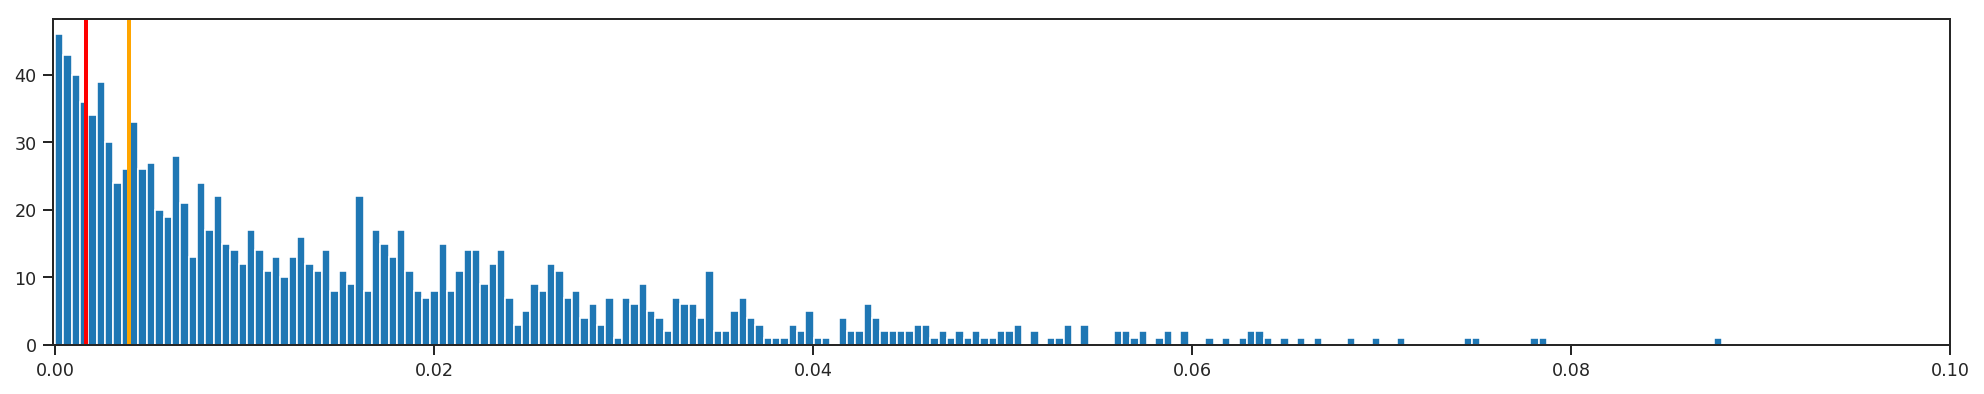

In [42]:
def get_mpd_by_coding_position(coding_position, minlen, maxlen):
    if maxlen == None:
        maxlen = np.inf
    exon_positions = ((seq_cls == CLS_EXON_LAST) | (seq_cls == CLS_EXON_MID) | (seq_cls == CLS_EXON_FIRST)) & (seq_codonpos == coding_position) & (seq_flen >= minlen) & (seq_flen <= maxlen)
    exon_values = seq_mpd[exon_positions]
    seq_exon_group_values = seq_exon_group[exon_positions]
    exon_values_grouped = pd.Series(exon_values).groupby(seq_exon_group_values)
    exon_group_sizefilter = exon_values_grouped.size() >= 20
    exon_group_mpd = exon_values_grouped.mean()[exon_group_sizefilter]
    return exon_group_mpd

# First coding position
exon_group_mpd_100max_1 = get_mpd_by_coding_position(1, 0, 100)
# Second coding position
exon_group_mpd_100max_2 = get_mpd_by_coding_position(2, 0, 100)
# Third coding position
exon_group_mpd_100max_3 = get_mpd_by_coding_position(3, 0, 100)

# What proportion of the distributions is at least as small as each of those exons?
print('First coding position:')
print(np.sum(exon_group_mpd_100max_1 <= np.mean(dsx_exon_mean_mpd_1[1])) / len(exon_group_mpd_100max_1))
print(np.sum(exon_group_mpd_100max_1 <= np.mean(dsx_exon_mean_mpd_1[3])) / len(exon_group_mpd_100max_1))
# It's 13% for both (becuase both have no variation, which is the case for 12% of exons)
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100max_1, bins = 2000)
ax.axvline(dsx_exon_mean_mpd_1[1], color='red', lw = 2)
ax.axvline(dsx_exon_mean_mpd_1[3], color='orange', lw = 2)
ax.set_xlim(left=-0.0001, right=0.01)
plt.show()
#
print('Second coding position:')
print(np.sum(exon_group_mpd_100max_2 <= np.mean(dsx_exon_mean_mpd_2[1])) / len(exon_group_mpd_100max_2))
print(np.sum(exon_group_mpd_100max_2 <= np.mean(dsx_exon_mean_mpd_2[3])) / len(exon_group_mpd_100max_2))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100max_2, bins = 2000)
ax.axvline(dsx_exon_mean_mpd_2[1], color='red', lw = 2)
ax.axvline(dsx_exon_mean_mpd_2[3], color='orange', lw = 2)
ax.set_xlim(left=-0.0001, right=0.01)
plt.show()
#
print('Third coding position:')
print(np.sum(exon_group_mpd_100max_3 <= np.mean(dsx_exon_mean_mpd_3[1])) / len(exon_group_mpd_100max_3))
print(np.sum(exon_group_mpd_100max_3 <= np.mean(dsx_exon_mean_mpd_3[3])) / len(exon_group_mpd_100max_3))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100max_3, bins = 200)
ax.axvline(dsx_exon_mean_mpd_3[1], color='red', lw = 2)
ax.axvline(dsx_exon_mean_mpd_3[3], color='orange', lw = 2)
ax.set_xlim(left=-0.0001, right=0.1)
plt.show()

# None of these look particularly impressive
# The red line is the Cas9 target codon

First coding position:
0.051925465838509315


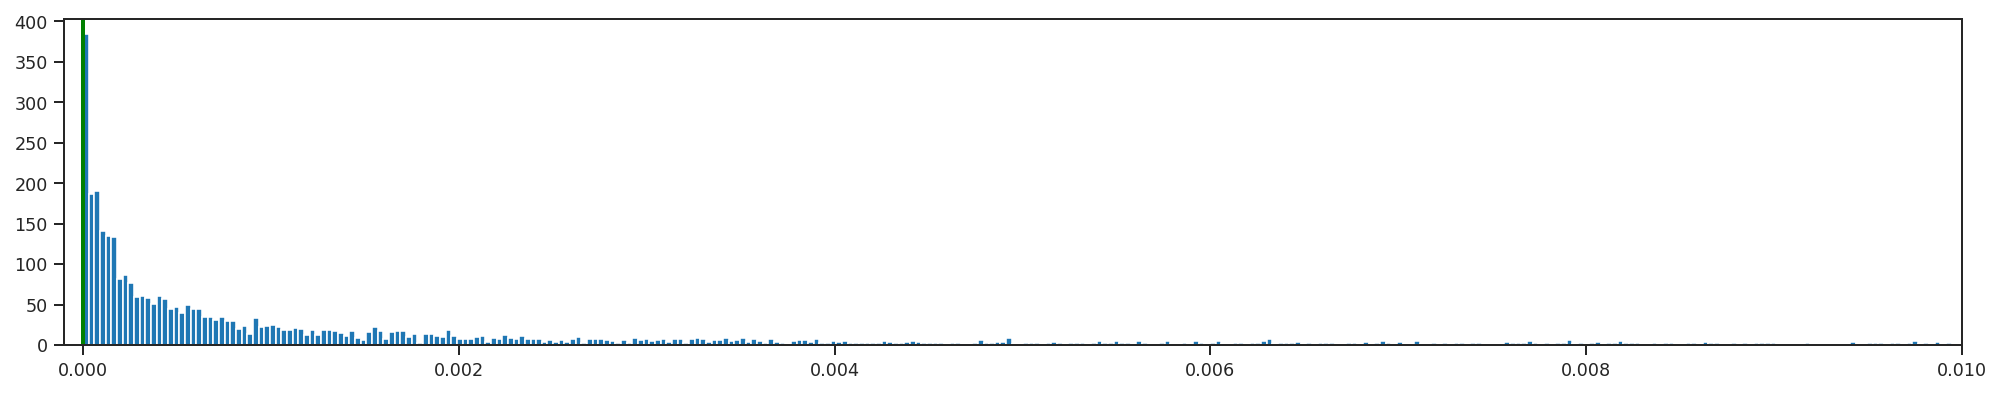

Second coding position:
0.4670807453416149


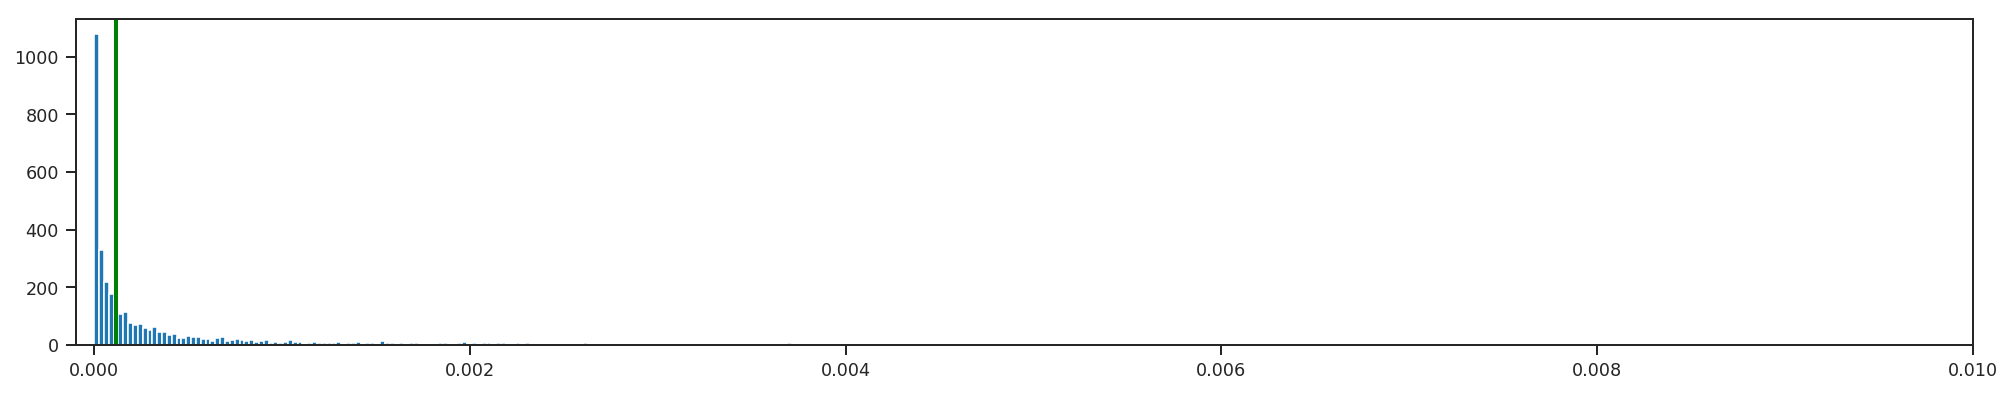

Third coding position:
0.07506835694755158


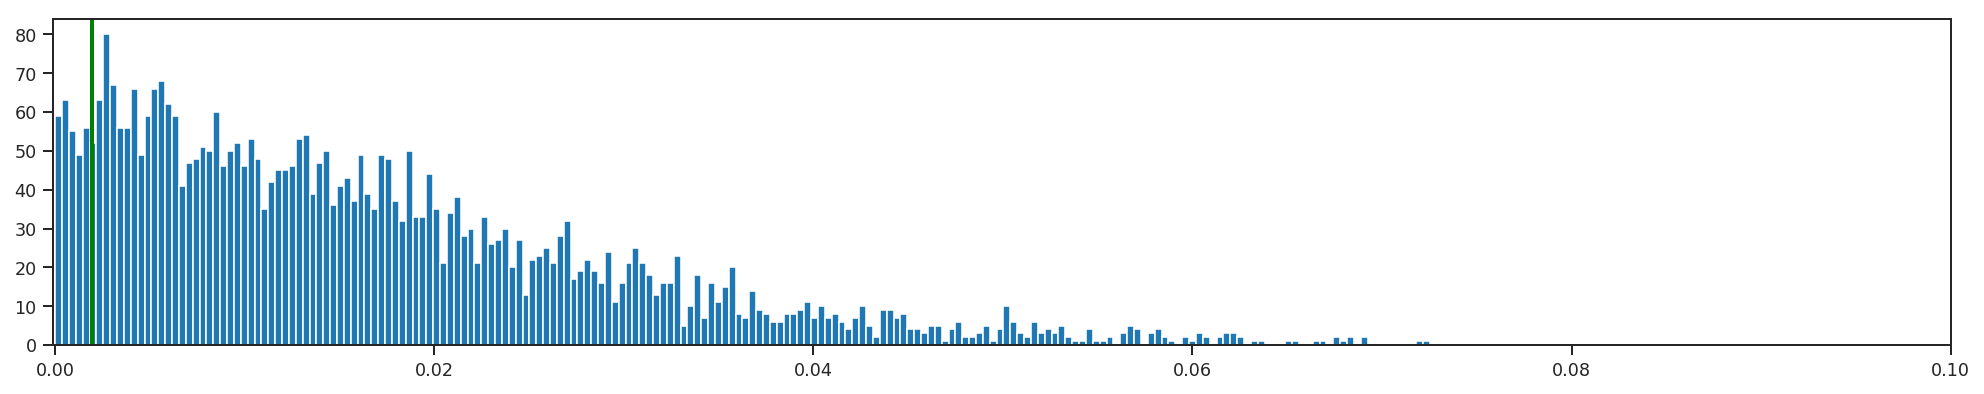

In [43]:
# For the 135bp-long exon, we use the 100-200 size range
exon_group_mpd_100_200_1 = get_mpd_by_coding_position(1, 100, 200)
exon_group_mpd_100_200_2 = get_mpd_by_coding_position(2, 100, 200)
exon_group_mpd_100_200_3 = get_mpd_by_coding_position(3, 100, 200)

print('First coding position:')
print(np.sum(exon_group_mpd_100_200_1 <= np.mean(dsx_exon_mean_mpd_1[2])) / len(exon_group_mpd_100_200_1))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100_200_1, bins = 2000)
ax.axvline(dsx_exon_mean_mpd_1[2], color='green', lw = 2)
ax.set_xlim(left=-0.0001, right=0.01)
plt.show()

print('Second coding position:')
print(np.sum(exon_group_mpd_100_200_2 <= np.mean(dsx_exon_mean_mpd_2[2])) / len(exon_group_mpd_100_200_2))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100_200_2, bins = 2000)
ax.axvline(dsx_exon_mean_mpd_2[2], color='green', lw = 2)
ax.set_xlim(left=-0.0001, right=0.01)
plt.show()

print('Third coding position:')
print(np.sum(exon_group_mpd_100_200_3 <= np.mean(dsx_exon_mean_mpd_3[2])) / len(exon_group_mpd_100_200_3))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_100_200_3, bins = 200)
ax.axvline(dsx_exon_mean_mpd_3[2], color='green', lw = 2)
ax.set_xlim(left=-0.0001, right=0.1)
plt.show()


First coding position:
0.06152782578638092
0.4044244728655375


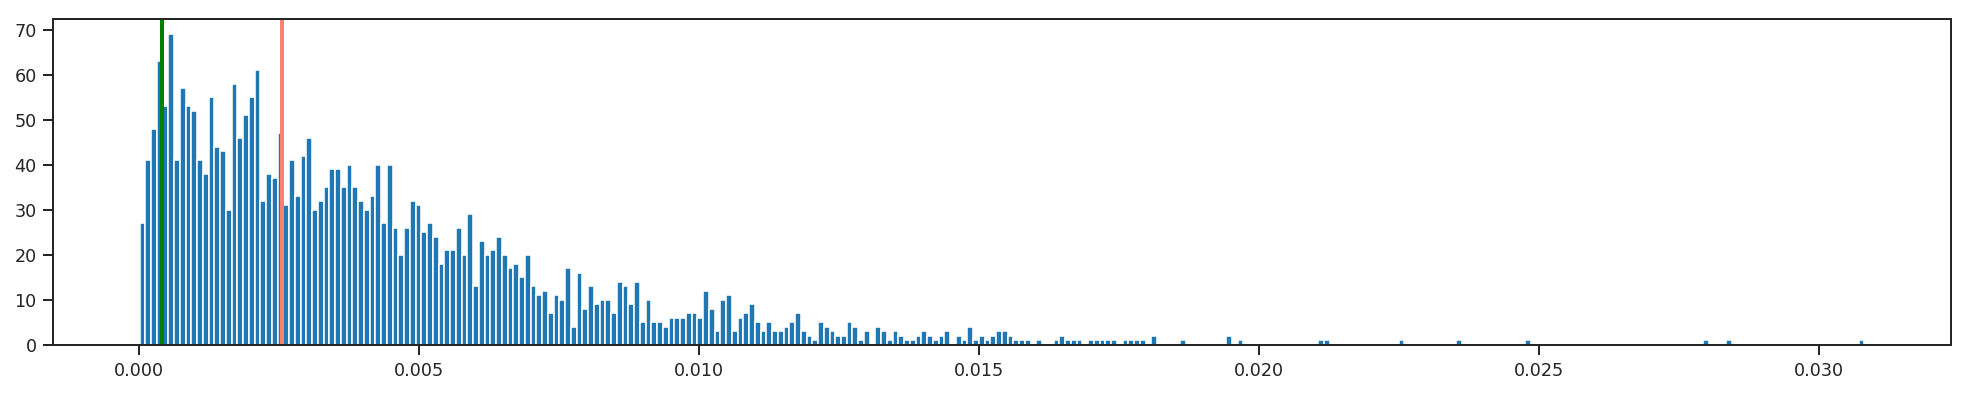

Second coding position:
0.03525751814725199
0.22640857241617698


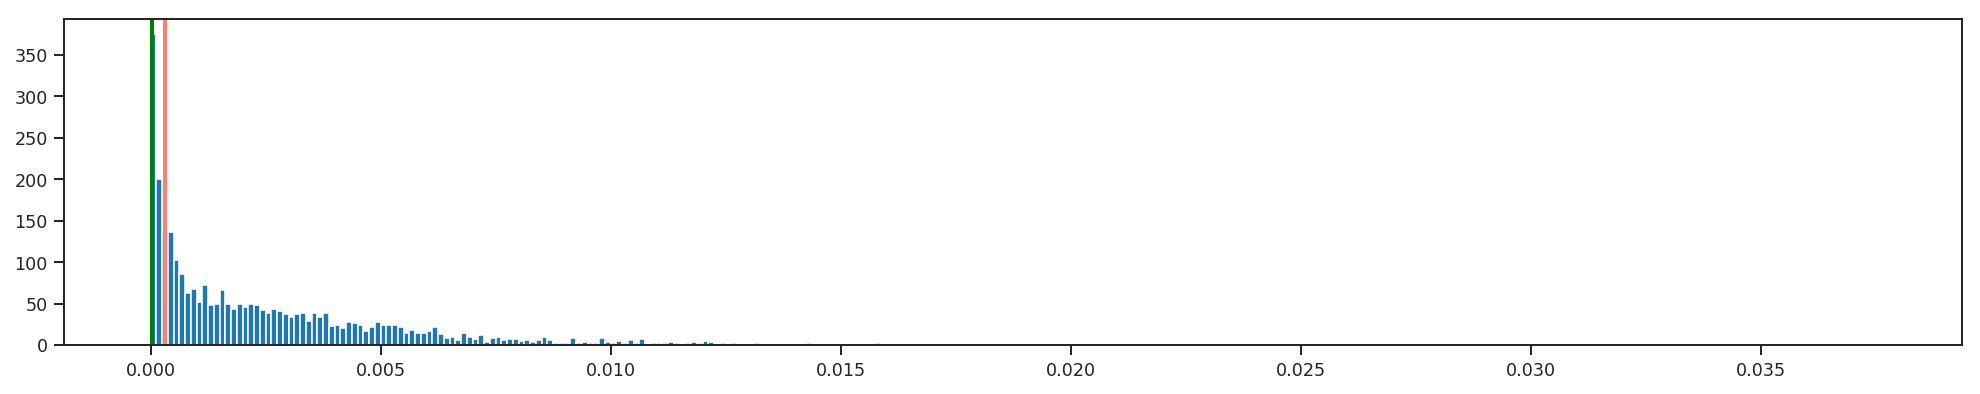

Third coding position:
0.04493605254061528
0.2170756999654338


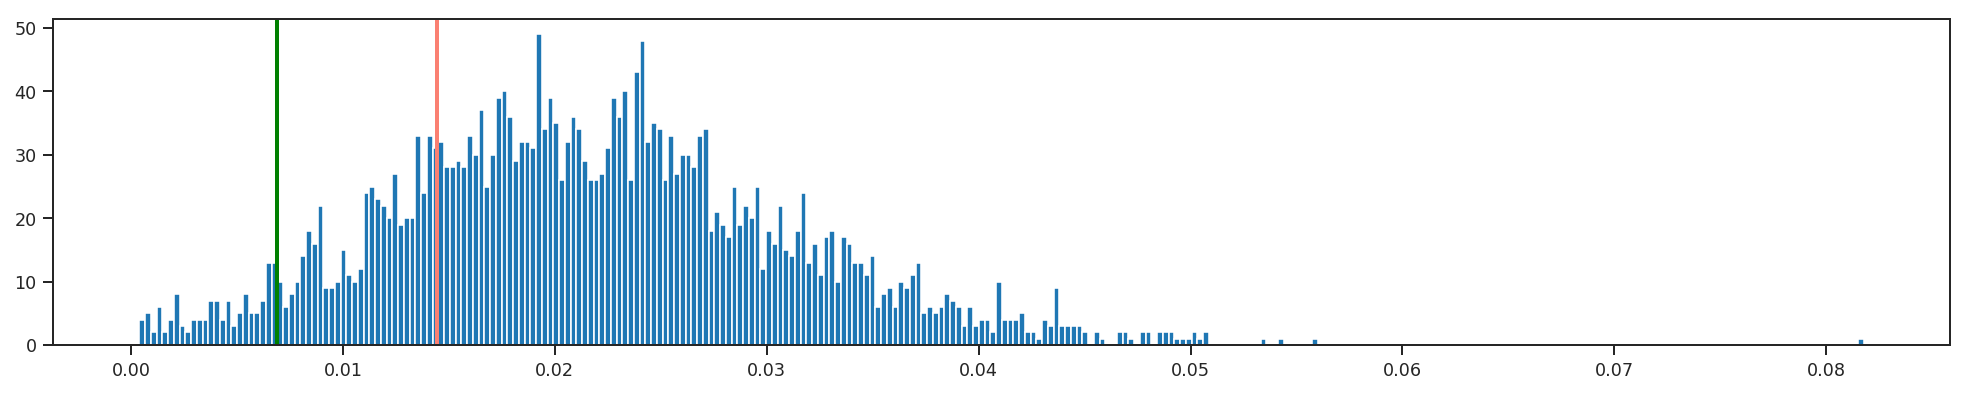

In [44]:
# For the longest exons, we use the 500+ distribution
exon_group_mpd_500plus_1 = get_mpd_by_coding_position(1, 500, None)
exon_group_mpd_500plus_2 = get_mpd_by_coding_position(2, 500, None)
exon_group_mpd_500plus_3 = get_mpd_by_coding_position(3, 500, None)

print('First coding position:')
print(np.sum(exon_group_mpd_500plus_1 <= np.mean(dsx_exon_mean_mpd_1[4])) / len(exon_group_mpd_500plus_1))
print(np.sum(exon_group_mpd_500plus_1 <= np.mean(dsx_exon_mean_mpd_1[0])) / len(exon_group_mpd_500plus_1))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_500plus_1, bins = 300)
ax.axvline(dsx_exon_mean_mpd_1[4], color='green', lw = 2)
ax.axvline(dsx_exon_mean_mpd_1[0], color='salmon', lw = 2)
plt.show()

print('Second coding position:')
print(np.sum(exon_group_mpd_500plus_2 <= np.mean(dsx_exon_mean_mpd_2[4])) / len(exon_group_mpd_500plus_2))
print(np.sum(exon_group_mpd_500plus_2 <= np.mean(dsx_exon_mean_mpd_2[0])) / len(exon_group_mpd_500plus_2))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_500plus_2, bins = 300)
ax.axvline(dsx_exon_mean_mpd_2[4], color='green', lw = 2)
ax.axvline(dsx_exon_mean_mpd_2[0], color='salmon', lw = 2)
plt.show()

print('Third coding position:')
print(np.sum(exon_group_mpd_500plus_3 <= np.mean(dsx_exon_mean_mpd_3[4])) / len(exon_group_mpd_500plus_3))
print(np.sum(exon_group_mpd_500plus_3 <= np.mean(dsx_exon_mean_mpd_3[0])) / len(exon_group_mpd_500plus_3))
fig, ax = plt.subplots(figsize=(17, 3))
ax.hist(exon_group_mpd_500plus_3, bins = 300)
ax.axvline(dsx_exon_mean_mpd_3[4], color='green', lw = 2)
ax.axvline(dsx_exon_mean_mpd_3[0], color='salmon', lw = 2)
plt.show()



In [45]:
# Right, now let's make a plot of of whole gene, showing the first and last 50bp of each feature.
# We will not include the UTRs, just the exons and introns. Since the gene is in the reverse reading
# frame, the start point of the exon is its "end point" as far as genomic coordinates are concerned.

# Set up the colours
exon_start_col = 'xkcd:sky blue'
exon_end_col = 'tab:blue'
intron_start_col = 'xkcd:fresh green'
intron_end_col = 'xkcd:leaf green'


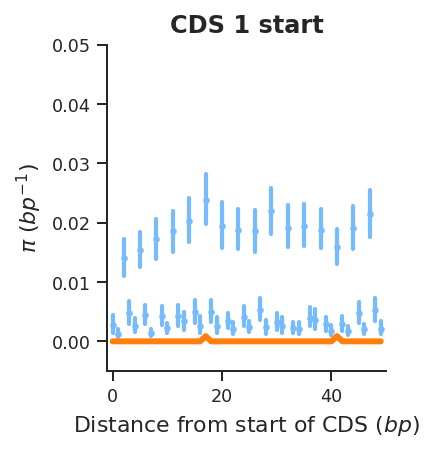

In [46]:
# First CDS:
def plot_cds_1_start(cds_start = dsx_exon_end_pos[4], startphase = 1, fig = None, figure_pos = None, bp_lim = 50, lefthandmostplot = True, shrink = 20):
    # Since the gene is in the reverse reading frame, the first 50bp of the cds are BEFORE the start
    # point in therms of genomic coordinates
    target_range = range(cds_start-bp_lim, cds_start)
    target_acc = accessibility_filter[target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    #cls = [CLS_EXON_FIRST]
    cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    y_min = -0.005
    y_max = 0.05
    min_flen = 500
    max_flen = np.inf

    # obtain variables
    flt = np.isin(seq_cls, cls) & (seq_startphase == startphase) & (seq_relpos < bp_lim) & (seq_flen >= min_flen) & (seq_flen <= max_flen)
    dist = seq_relpos[flt]
    values = seq_mpd[flt]

    # plot
    x_coords = range(bp_lim)
    if fig is None:
        fig, ax = plt.subplots(figsize=(len(x_coords)/shrink, 3))
    else:
        if figure_pos is None:
            raise Exception('You need to give me figure coordinates.')
        ax = fig.add_axes(figure_pos)
    # Plot the mean data
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_start_col)
    # Plot dsx data
    ax.plot(x_coords, target_mpd[::-1], lw=3, color = 'tab:orange')
    # Show any accessibility-fitered positions
    ax.scatter(np.array(x_coords)[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=1, c = 'red')   
    ax.set_xlim(left=-1)
    ax.set_xlabel('Distance from start of CDS ($bp$)', fontsize=11)
    ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    title = 'CDS 1 start'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if (not lefthandmostplot):
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.autoscale(tight = True)
    else:
        ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
        ax.set_xlim(left = -1, right = bp_lim)
    ax.set_ylim(bottom=y_min, top=y_max)
    # If being plotted as part of a big figure, that big figure will need to know how wide this figure is


plot_cds_1_start()
plt.show()

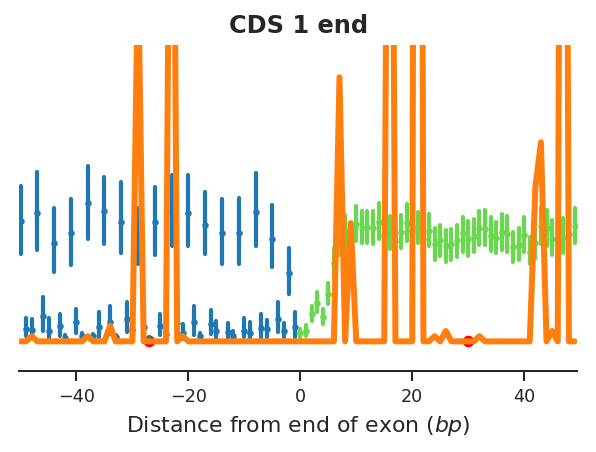

In [47]:
# End of cds 1
def plot_cds_1_end(cds_end = dsx_exon_start_pos[4], endphase = 1, fig = None, figure_pos = None, bp_lim = 50, lefthandmostplot = False, shrink = 20):
    target_range = range(cds_end-bp_lim, cds_end+bp_lim)
    target_acc = accessibility_filter[target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    #cds_cls = [CLS_EXON_FIRST]
    cds_cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    #intron_cls = [CLS_INTRON_FIRST]
    intron_cls = [CLS_INTRON_FIRST, CLS_INTRON_MID, CLS_INTRON_LAST]
    y_min = -0.005
    y_max = 0.05
    min_cds_flen = 500
    max_cds_flen = np.inf
    min_intron_flen = 300

    # obtain variables
    cds_flt = np.isin(seq_cls, cds_cls) & (seq_endphase == endphase) & (seq_relpos_end < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_flt = np.isin(seq_cls, intron_cls) & (seq_relpos < bp_lim) & (seq_flen >= min_intron_flen)
    cds_dist = -(1+seq_relpos_end[cds_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    cds_values = seq_mpd[cds_flt]
    intron_dist = seq_relpos[intron_flt].astype('int')
    intron_values = seq_mpd[intron_flt]
    
    # plot
    x_coords = range(-bp_lim,bp_lim)
    if fig is None:
        fig, ax = plt.subplots(figsize=(len(x_coords)/shrink, 3))
    else:
        if figure_pos is None:
            raise Exception('You need to give me figure coordinates.')
        ax = fig.add_axes(figure_pos)
    sns.regplot(cds_dist, cds_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_end_col)
    sns.regplot(intron_dist, intron_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = intron_start_col)
    ax.plot(x_coords, target_mpd[::-1], lw=3, color = 'tab:orange')
    ax.scatter(np.array(x_coords)[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=1, c = 'red')   
    ax.set_xlabel('Distance from end of exon ($bp$)', fontsize=11)
    title = 'CDS 1 end'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if (not lefthandmostplot):
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.autoscale(tight = True)
    else:
        ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    ax.set_ylim(bottom=y_min, top=y_max)

plot_cds_1_end()
plt.show()

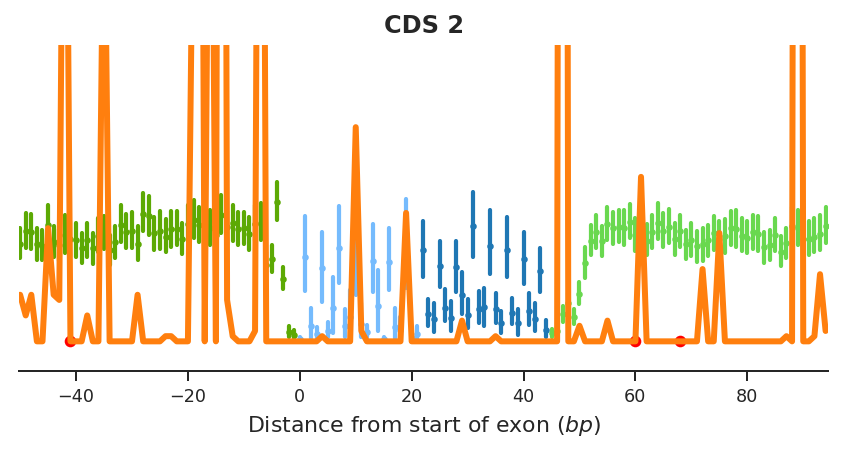

In [48]:
# cds 2 is only 45 bp long, so we encompass it all in a single plot, along with the introns either side
def plot_cds_2(cds_start = dsx_exon_end_pos[3], cds_end = dsx_exon_start_pos[3], startphase = 2, endphase = 1, fig = None, figure_pos = None,  bp_lim = 50, lefthandmostplot = False, shrink = 20):
    target_range = range(cds_end-bp_lim, cds_start+bp_lim)
    target_acc = accessibility_filter[target_range]
    target_mpd = seq_mpd_nofilter[target_range]
        
    #cds_cls = [CLS_EXON_MID]
    cds_cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    # The end of the intron we are showing is the first intron, but the start is the second intron
    #intron_end_cls = [CLS_INTRON_FIRST]
    #intron_start_cls = [CLS_INTRON_MID]
    intron_end_cls = [CLS_INTRON_FIRST, CLS_INTRON_MID, CLS_INTRON_LAST]
    intron_start_cls = [CLS_INTRON_FIRST, CLS_INTRON_MID, CLS_INTRON_LAST]
    y_min = -0.005
    y_max = 0.05
    min_cds_flen = 0
    max_cds_flen = 100
    min_intron_flen = 300

    # Find the midpoint of the CDS region (before this point, we will compare with the chromosome average
    # relative to cds start points, after the midpoint, we will compare with the chromosome average relative
    # to the cds end points).
    cds_len = cds_start - cds_end
    cds_midpoint = cds_len//2
    cds_start_flt = np.isin(seq_cls, cds_cls) & (seq_startphase == startphase) & (seq_relpos < cds_midpoint) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    cds_end_flt = np.isin(seq_cls, cds_cls) & (seq_endphase == endphase) & (seq_relpos_end < (cds_len - cds_midpoint)) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_end_flt = np.isin(seq_cls, intron_end_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_intron_flen)
    intron_start_flt = np.isin(seq_cls, intron_start_cls) & (seq_relpos < bp_lim) & (seq_flen >= min_intron_flen)
    cds_start_dist = seq_relpos[cds_start_flt].astype('int')
    cds_end_dist = -(1+seq_relpos_end[cds_end_flt].astype('int')) + cds_len # Need to change dtype here because can't take a negative of unsigned integer
    cds_start_values = seq_mpd[cds_start_flt]
    cds_end_values = seq_mpd[cds_end_flt]
    intron_end_dist = -(1+seq_relpos_end[intron_end_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    intron_end_values = seq_mpd[intron_end_flt]
    intron_start_dist = seq_relpos[intron_start_flt].astype('int') + cds_len
    intron_start_values = seq_mpd[intron_start_flt]
    
    # plot
    x_coords = range(-bp_lim,len(target_mpd)-bp_lim)
    if fig is None:
        fig, ax = plt.subplots(figsize=(len(x_coords)/shrink, 3))
    else:
        if figure_pos is None:
            raise Exception('You need to give me figure coordinates.')
        ax = fig.add_axes(figure_pos)
    sns.regplot(intron_end_dist, intron_end_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = intron_end_col)
    sns.regplot(cds_start_dist, cds_start_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_start_col)
    sns.regplot(cds_end_dist, cds_end_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_end_col)
    sns.regplot(intron_start_dist, intron_start_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = intron_start_col)
    ax.plot(x_coords, target_mpd[::-1], lw=3, color = 'tab:orange')
    ax.scatter(np.array(x_coords)[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=1, c = 'red')   
    ax.set_xlabel('Distance from start of exon ($bp$)', fontsize=11)
    title = 'CDS 2'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if (not lefthandmostplot):
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.autoscale(tight = True)
    else:
        ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    ax.set_ylim(bottom=y_min, top=y_max)

plot_cds_2()
plt.show()

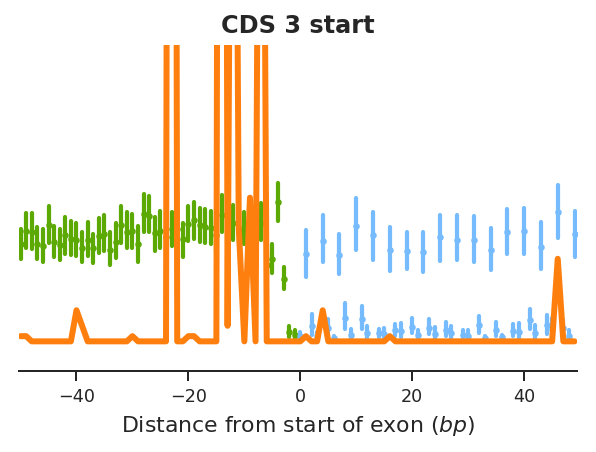

In [49]:
# Start of cds 3
def plot_cds_3_start(cds_start = dsx_exon_end_pos[2], startphase = 2, fig = None, figure_pos = None, bp_lim = 50, lefthandmostplot = False, shrink = 20):
    target_range = range(cds_start-bp_lim, cds_start+bp_lim)
    target_acc = accessibility_filter[target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    #cds_cls = [CLS_EXON_MID]
    cds_cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    #intron_cls = [CLS_INTRON_MID]
    intron_cls = [CLS_INTRON_FIRST, CLS_INTRON_MID, CLS_INTRON_LAST]
    y_min = -0.005
    y_max = 0.05
    min_cds_flen = 100
    max_cds_flen = 200
    min_intron_flen = 300

    # obtain variables
    cds_flt = np.isin(seq_cls, cds_cls) & (seq_startphase == startphase)  & (seq_relpos < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_flt = np.isin(seq_cls, intron_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_intron_flen)
    cds_dist = seq_relpos[cds_flt].astype('int')
    cds_values = seq_mpd[cds_flt]
    intron_dist = -(1+seq_relpos_end[intron_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    intron_values = seq_mpd[intron_flt]
    
    # plot
    x_coords = range(-bp_lim,bp_lim)
    if fig is None:
        fig, ax = plt.subplots(figsize=(len(x_coords)/shrink, 3))
    else:
        if figure_pos is None:
            raise Exception('You need to give me figure coordinates.')
        ax = fig.add_axes(figure_pos)
    sns.regplot(intron_dist, intron_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = intron_end_col)
    sns.regplot(cds_dist, cds_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_start_col)
    ax.plot(x_coords, target_mpd[::-1], lw=3, color = 'tab:orange')
    ax.scatter(np.array(x_coords)[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=1, c = 'red')   
    ax.set_xlabel('Distance from start of exon ($bp$)', fontsize=11)
    title = 'CDS 3 start'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if (not lefthandmostplot):
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.autoscale(tight = True)
    else:
        ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    ax.set_ylim(bottom=y_min, top=y_max)

plot_cds_3_start()
plt.show()

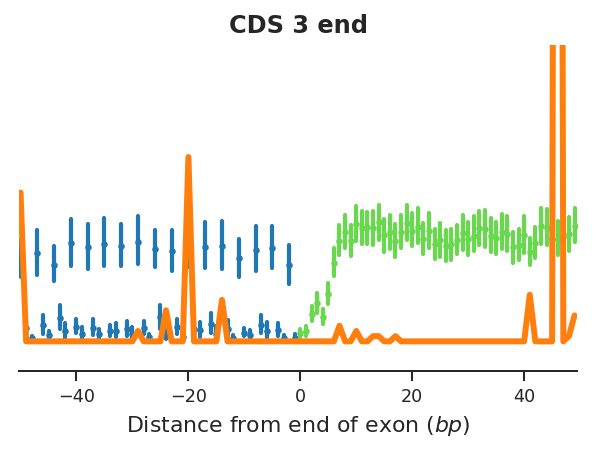

In [50]:
# End of cds3
def plot_cds_3_end(cds_end = dsx_exon_start_pos[2], endphase = 1, fig = None, figure_pos = None, bp_lim = 50, lefthandmostplot = False, shrink = 20):
    target_range = range(cds_end-bp_lim, cds_end+bp_lim)
    target_acc = accessibility_filter[target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    #cds_cls = [CLS_EXON_MID]
    cds_cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    #intron_cls = [CLS_INTRON_LAST]
    intron_cls = [CLS_INTRON_FIRST, CLS_INTRON_MID, CLS_INTRON_LAST]
    y_min = -0.005
    y_max = 0.05
    min_cds_flen = 100
    max_cds_flen = 200
    min_intron_flen = 300

    # obtain variables
    cds_flt = np.isin(seq_cls, cds_cls) & (seq_endphase == endphase)  & (seq_relpos_end < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_flt = np.isin(seq_cls, intron_cls) & (seq_relpos < bp_lim) & (seq_flen >= min_intron_flen)
    cds_dist = -(1+seq_relpos_end[cds_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    cds_values = seq_mpd[cds_flt]
    intron_dist = seq_relpos[intron_flt].astype('int')
    intron_values = seq_mpd[intron_flt]
    
    # plot
    x_coords = range(-bp_lim,bp_lim)
    if fig is None:
        fig, ax = plt.subplots(figsize=(len(x_coords)/shrink, 3))
    else:
        if figure_pos is None:
            raise Exception('You need to give me figure coordinates.')
        ax = fig.add_axes(figure_pos)
    sns.regplot(cds_dist, cds_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_end_col)
    sns.regplot(intron_dist, intron_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = intron_start_col)
    ax.plot(x_coords, target_mpd[::-1], lw=3, color = 'tab:orange')
    ax.scatter(np.array(x_coords)[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=1, c = 'red')   
    ax.set_xlabel('Distance from end of exon ($bp$)', fontsize=11)
    title = 'CDS 3 end'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if (not lefthandmostplot):
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.autoscale(tight = True)
    else:
        ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    ax.set_ylim(bottom=y_min, top=y_max)

plot_cds_3_end()
plt.show()

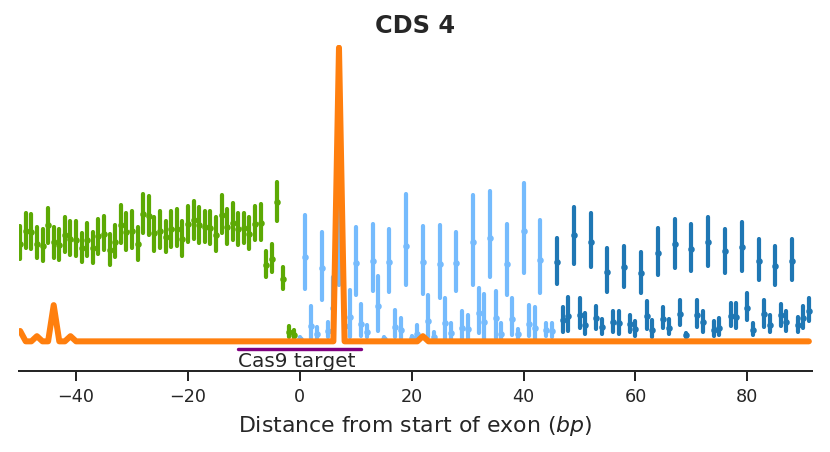

In [51]:
# female cds 4 is only 92 bp long, so we encompass it all in a single plot, along with the intron
# upstream.
def plot_cds_4f(cds_start = dsx_exon_end_pos[1], cds_end = dsx_exon_start_pos[1], startphase = 2, endphase = 3, fig = None, figure_pos = None, bp_lim = 50, lefthandmostplot = False, shrink = 20):
    target_range = range(cds_end, cds_start+bp_lim)
    target_acc = accessibility_filter[target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    #cds_cls = [CLS_EXON_LAST]
    cds_cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    #intron_cls = [CLS_INTRON_LAST]
    intron_cls = [CLS_INTRON_FIRST, CLS_INTRON_MID, CLS_INTRON_LAST]
    y_min = -0.005
    y_max = 0.05
    min_cds_flen = 0
    max_cds_flen = 100
    min_intron_flen = 300

    # Find the midpoint of the CDS region (before this point, we will compare with the chromosome average
    # relative to cds start points, after the midpoint, we will compare with the chromosome average relative
    # to the cds end points).
    cds_len = cds_start - cds_end
    cds_midpoint = cds_len//2
    cds_start_flt = np.isin(seq_cls, cds_cls) & (seq_startphase == startphase)  & (seq_relpos < cds_midpoint) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    cds_end_flt = np.isin(seq_cls, cds_cls) & (seq_endphase == endphase) & (seq_relpos_end < (cds_len - cds_midpoint)) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_end_flt = np.isin(seq_cls, intron_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_intron_flen)
    cds_start_dist = seq_relpos[cds_start_flt].astype('int')
    cds_end_dist = -(1+seq_relpos_end[cds_end_flt].astype('int')) + cds_len # Need to change dtype here because can't take a negative of unsigned integer
    cds_start_values = seq_mpd[cds_start_flt]
    cds_end_values = seq_mpd[cds_end_flt]
    intron_end_dist = -(1+seq_relpos_end[intron_end_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    intron_end_values = seq_mpd[intron_end_flt]

    # plot
    x_coords = range(-bp_lim,len(target_mpd)-bp_lim)
    if fig is None:
        fig, ax = plt.subplots(figsize=(len(x_coords)/shrink, 3))
    else:
        if figure_pos is None:
            raise Exception('You need to give me figure coordinates.')
        ax = fig.add_axes(figure_pos)
    sns.regplot(intron_end_dist, intron_end_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = intron_end_col)
    sns.regplot(cds_start_dist, cds_start_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_start_col)
    sns.regplot(cds_end_dist, cds_end_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_end_col)
    ax.plot(x_coords, target_mpd[::-1], lw=3, color = 'tab:orange')
    ax.scatter(np.array(x_coords)[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=1, c = 'red')   
    # Indicate the Cas9 target region
    ax.plot(range(-11,12), [-0.0013]*23, lw=1.7, color = 'purple')
    ax.text(-11, -0.0042, 'Cas9 target')
    ax.set_xlabel('Distance from start of exon ($bp$)', fontsize=11)
    title = 'CDS 4'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if (not lefthandmostplot):
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.autoscale(tight = True)
    else:
        ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    ax.set_ylim(bottom=y_min, top=y_max)

plot_cds_4f()
plt.show()


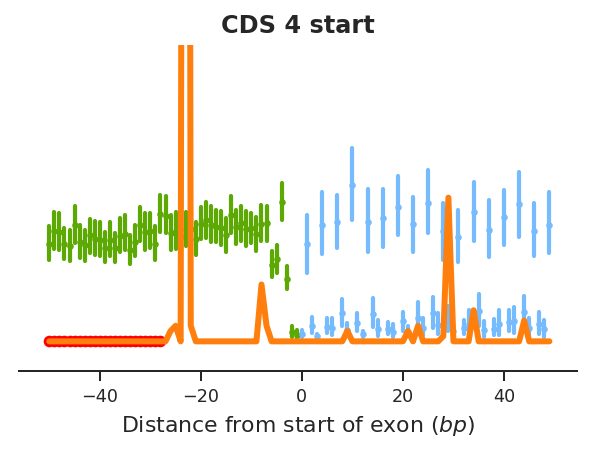

In [52]:
# Male cds is longer, so plot the start and end of it separately
def plot_cds_4m_start(cds_start = dsx_exon_end_pos[0], startphase = 2, fig = None, figure_pos = None, bp_lim = 50, lefthandmostplot = False, shrink = 20):
    target_range = range(cds_start-bp_lim, cds_start+bp_lim)
    target_acc = accessibility_filter[target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    #cds_cls = [CLS_EXON_LAST]
    cds_cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    #intron_cls = [CLS_INTRON_LAST]
    intron_cls = [CLS_INTRON_FIRST, CLS_INTRON_MID, CLS_INTRON_LAST]
    y_min = -0.005
    y_max = 0.05
    min_cds_flen = 500
    max_cds_flen = np.inf
    min_intron_flen = 300

    # obtain variables
    cds_flt = np.isin(seq_cls, cds_cls) & (seq_startphase == startphase)  & (seq_relpos < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    intron_flt = np.isin(seq_cls, intron_cls) & (seq_relpos_end < bp_lim) & (seq_flen >= min_intron_flen)
    cds_dist = seq_relpos[cds_flt].astype('int')
    cds_values = seq_mpd[cds_flt]
    intron_dist = -(1+seq_relpos_end[intron_flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    intron_values = seq_mpd[intron_flt]
    
    # plot
    x_coords = range(-bp_lim,bp_lim)
    if fig is None:
        fig, ax = plt.subplots(figsize=(len(x_coords)/shrink, 3))
    else:
        if figure_pos is None:
            raise Exception('You need to give me figure coordinates.')
        ax = fig.add_axes(figure_pos)
    sns.regplot(intron_dist, intron_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = intron_end_col)
    sns.regplot(cds_dist, cds_values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_start_col)
    ax.plot(x_coords, target_mpd[::-1], lw=3, color = 'tab:orange')
    ax.scatter(np.array(x_coords)[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=1, c = 'red')   
    ax.set_ylim(bottom=y_min, top=y_max)
    ax.set_xlabel('Distance from start of exon ($bp$)', fontsize=11)
    title = 'CDS 4 start'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if (not lefthandmostplot):
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
    else:
        ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)

plot_cds_4m_start()
plt.show()

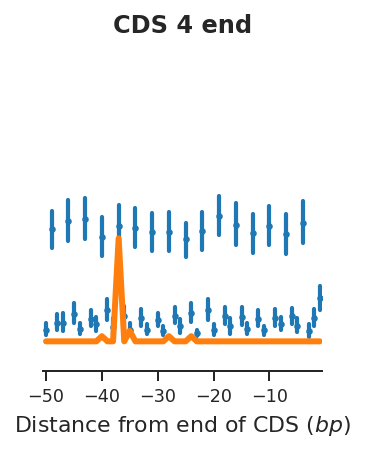

In [53]:
# And now the end of the male version of cds 4
def plot_cds_4m_end(cds_end = dsx_exon_start_pos[0], endphase = 3, fig = None, figure_pos = None, bp_lim = 50, lefthandmostplot = False, shrink= 20):
    target_range = range(cds_end, cds_end+bp_lim)
    target_acc = accessibility_filter[target_range]
    target_mpd = seq_mpd_nofilter[target_range]
    
    #cds_cls = [CLS_EXON_LAST]
    cds_cls = [CLS_EXON_FIRST, CLS_EXON_MID, CLS_EXON_LAST]
    y_min = -0.005
    y_max = 0.05
    min_cds_flen = 500
    max_cds_flen = np.inf

    # obtain variables
    flt = np.isin(seq_cls, cds_cls) & (seq_endphase == endphase) & (seq_relpos_end < bp_lim) & (seq_flen >= min_cds_flen) & (seq_flen <= max_cds_flen)
    dist = -(1+seq_relpos_end[flt].astype('int')) # Need to change dtype here because can't take a negative of unsigned integer
    values = seq_mpd[flt]
    
    # plot
    x_coords = range(-bp_lim,0)
    if fig is None:
        fig, ax = plt.subplots(figsize=(len(x_coords)/shrink, 3))
    else:
        if figure_pos is None:
            raise Exception('You need to give me figure coordinates.')
        ax = fig.add_axes(figure_pos)
    sns.regplot(dist, values, x_estimator=np.mean, fit_reg=False, ax=ax, scatter_kws=dict(s=6), color = exon_end_col)
    ax.plot(x_coords, target_mpd[::-1], lw=3, color = 'tab:orange')
    ax.scatter(np.array(x_coords)[np.invert(target_acc)[::-1]], target_mpd[np.invert(target_acc)][::-1], lw=1, c = 'red')   
    ax.set_xlabel('Distance from end of CDS ($bp$)', fontsize=11)
    title = 'CDS 4 end'
    ax.set_title(title, fontsize=12, fontweight='bold')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if (not lefthandmostplot):
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.autoscale(tight = True)
    else:
        ax.set_ylabel(r'$\pi$ ($bp^{-1}$)', fontsize=11)
    ax.set_ylim(bottom=y_min, top=y_max)

plot_cds_4m_end()
plt.show()

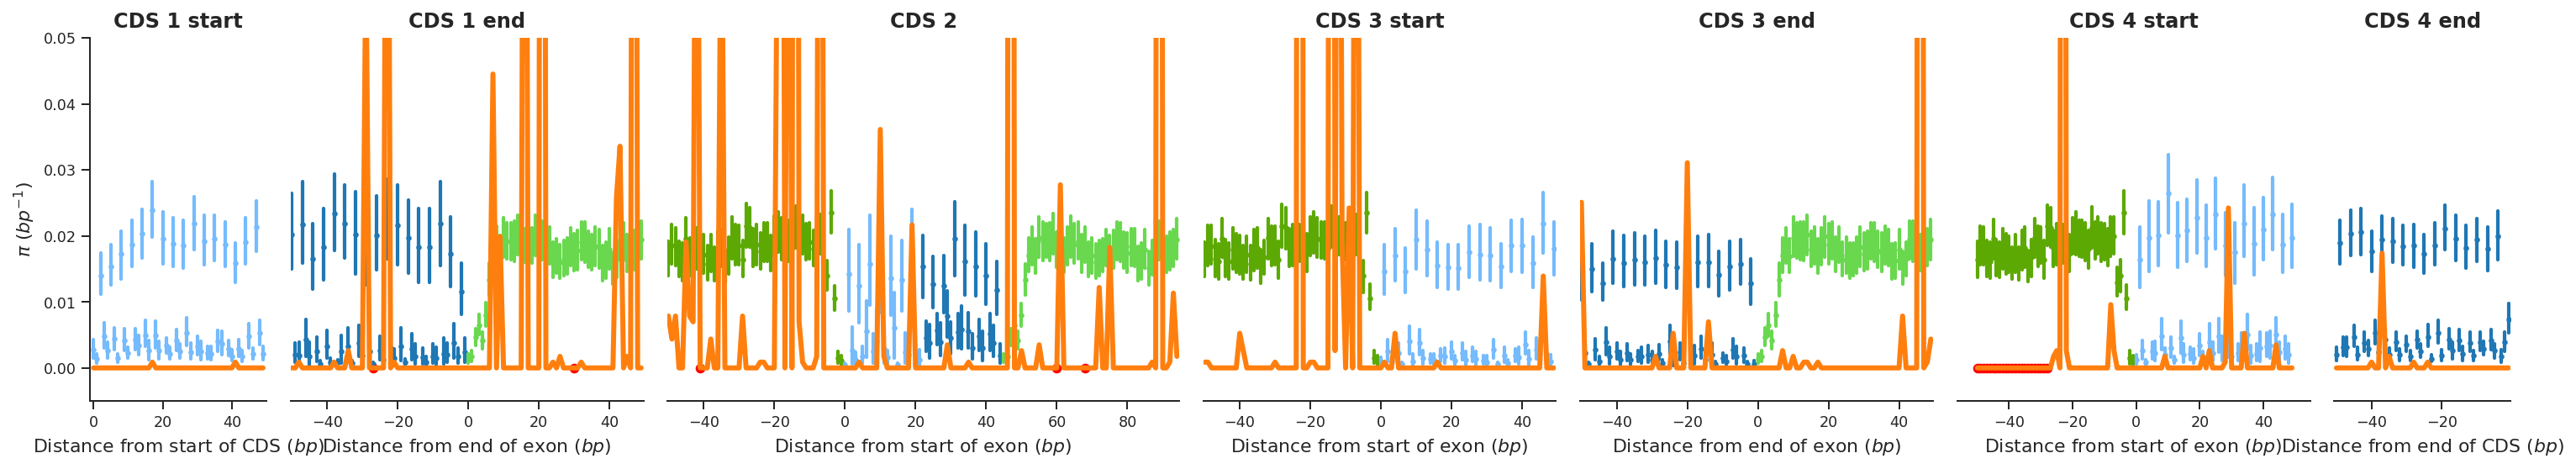

In [54]:
def plotter_of_plots_male(figwidth, gapsize):
    # work out the length that each plot will be
    plot1_size = 50
    plot2_size = 100
    plot3_size = len(range(dsx_exon_start_pos[3]-50, dsx_exon_end_pos[3]+50))
    plot4_size = 100
    plot5_size = 100
    plot6_size = 100
    plot7_size = 50
    plot_sizes = np.array([plot1_size, plot2_size, plot3_size, plot4_size, plot5_size, plot6_size, plot7_size])
    plot_functions = [plot_cds_1_start, plot_cds_1_end, plot_cds_2, plot_cds_3_start, plot_cds_3_end, plot_cds_4m_start, plot_cds_4m_end]
    # Get the proportion of the length of the figure represented by each plot, and leave a bit for the
    # space between plots
    plot_proportions = (1-(len(plot_sizes)-1)*gapsize) * plot_sizes / np.sum(plot_sizes)
    plot_starts = np.cumsum(np.insert(plot_proportions + gapsize, 0, 0)[:-1])
    fig = plt.figure(figsize = (figwidth, 3))
    for plotfunc, plotprop, plotstart in zip(plot_functions, plot_proportions, plot_starts):
        plotfunc(fig = fig, figure_pos = [plotstart, 0, plotprop, 1])

plotter_of_plots_male(20, 0.01)
plt.show()

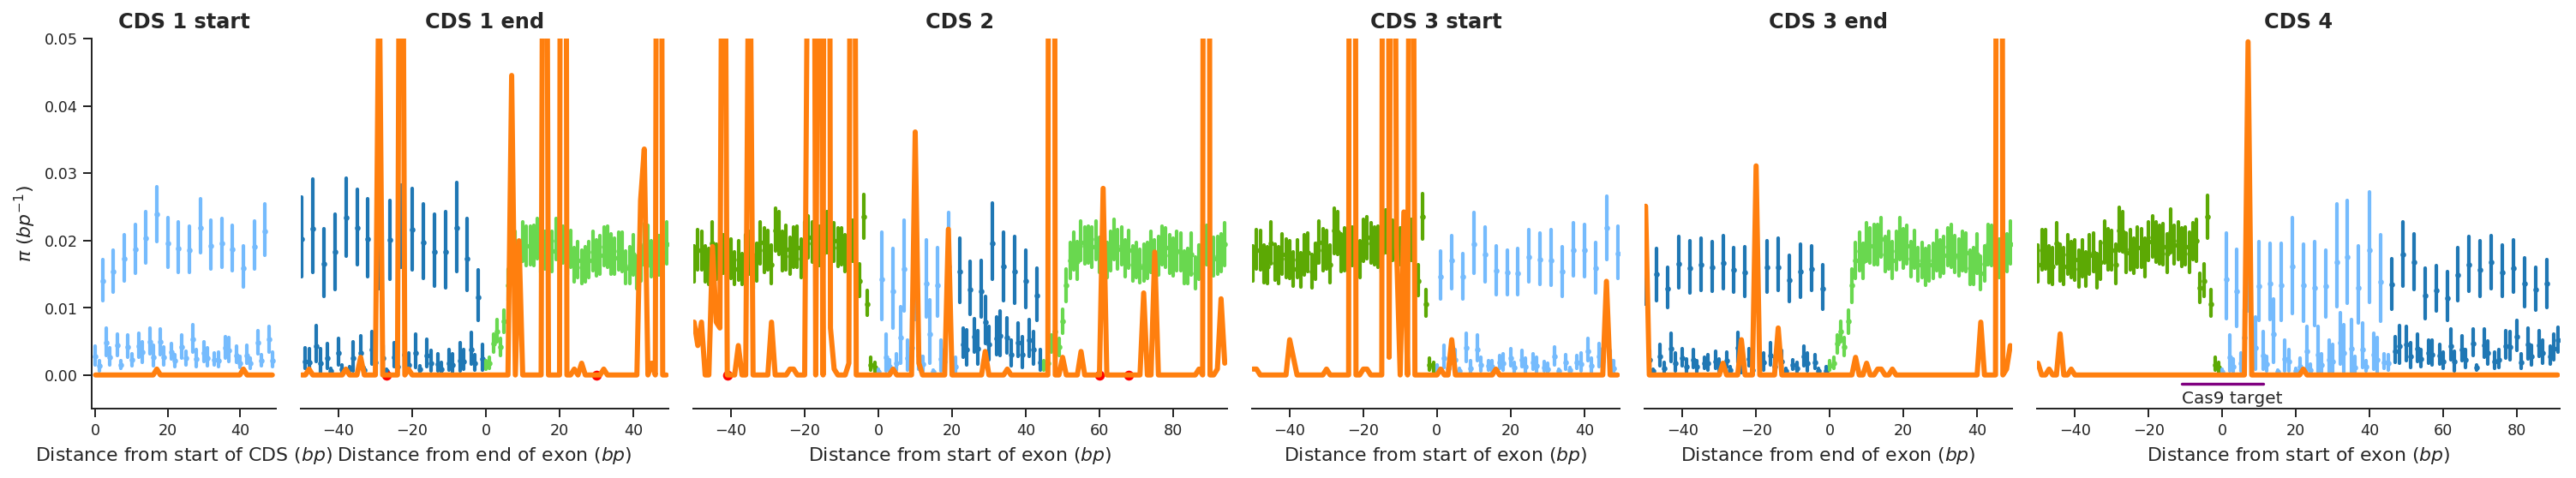

In [55]:
def plotter_of_plots_female(figwidth, gapsize):
    # work out the length that each plot will be
    plot1_size = 50
    plot2_size = 100
    plot3_size = len(range(dsx_exon_start_pos[3]-50, dsx_exon_end_pos[3]+50))
    plot4_size = 100
    plot5_size = 100
    plot6_size = len(range(dsx_exon_start_pos[1], dsx_exon_end_pos[1]+50))
    plot_sizes = np.array([plot1_size, plot2_size, plot3_size, plot4_size, plot5_size, plot6_size])
    plot_functions = [plot_cds_1_start, plot_cds_1_end, plot_cds_2, plot_cds_3_start, plot_cds_3_end, plot_cds_4f]
    # Get the proportion of the length of the figure represented by each plot, and leave a bit for the
    # space between plots
    plot_proportions = (1-(len(plot_sizes)-1)*gapsize) * plot_sizes / np.sum(plot_sizes)
    plot_starts = np.cumsum(np.insert(plot_proportions + gapsize, 0, 0)[:-1])
    fig = plt.figure(figsize = (figwidth, 3))
    for plotfunc, plotprop, plotstart in zip(plot_functions, plot_proportions, plot_starts):
        plotfunc(fig = fig, figure_pos = [plotstart, 0, plotprop, 1])

plotter_of_plots_female(20, 0.01)
plt.show()

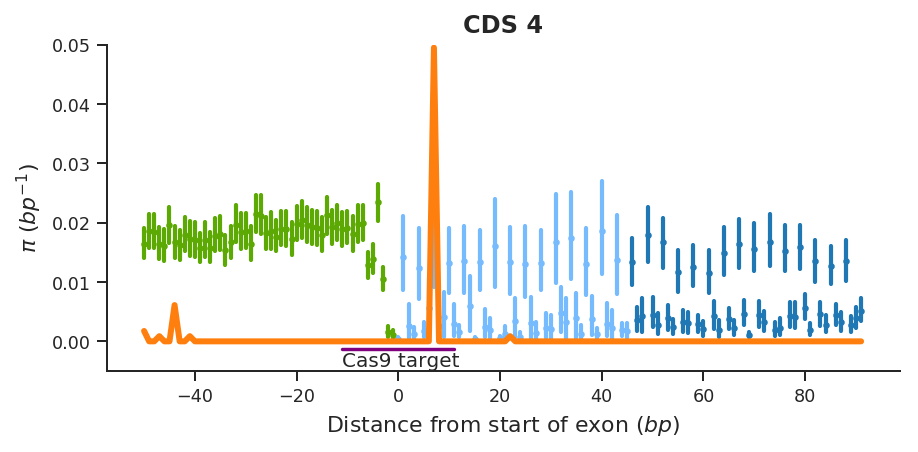

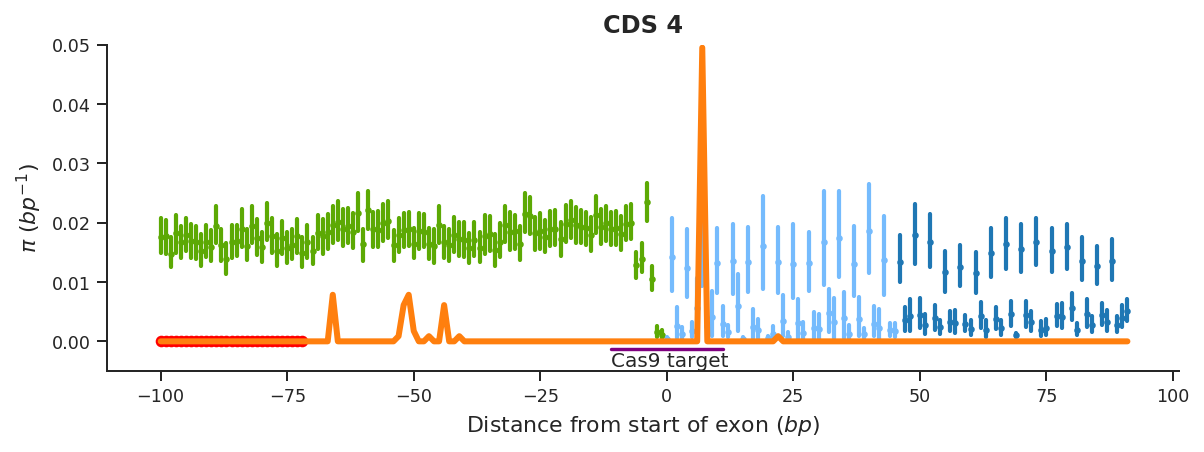

In [56]:
# Now let's make the plot for just the Cas9 target boundary
plot_cds_4f(lefthandmostplot= True)
plt.show()
plot_cds_4f(bp_lim = 100, lefthandmostplot= True)
plt.show()

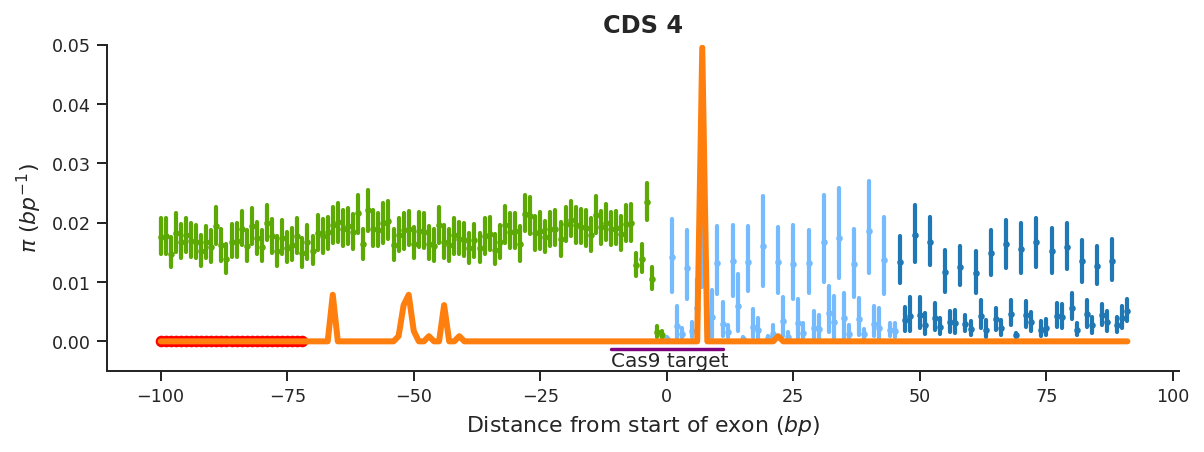

In [57]:
plot_cds_4f(bp_lim = 100, lefthandmostplot= True)
plt.savefig('Cas9_target_diversity.jpg', jpeg_quality = 100, dpi = 600, bbox_inches = 'tight')